# Sommaire

* [Chapitre 1 : Préparation de la base de données](#chapter1)
    * [Introduction](#section_1_1)
    * [Importation des données](#section_1_2)
    * [Matrice RFM](#section_1_3)
    
* [Chapitre 2 : Création de la base client](#chapter2)
    * [Données liées aux commandes](#section_2_1)
    * [Données liées aux articles](#section_2_2)
    * [Données liées à la géolocalisation](#section_2_3)
    * [Fusion des données](#section_2_4)
    
* [Chapitre 3 : Analyse des données](#chapter3)
    * [Analyse univariée](#section_3_1)
    * [Analyse bivariée](#section_3_2)
        * [Matrice de corrélation](#section_3_2_1)
        * [Régression linéaire](#section_3_2_1)
    * [Analyse multivariée](#section_3_3)
        * [Données brut](#section_3_3_1)
        * [Filtres](#section_3_3_2)
        * [Exportation des données](#section_3_3_3)
    * [Données pour la maintenance](#section_3_4)

<a class="anchor" id="chapter1"></a>
# Chapitre 1 : Préparation de la base de données
<a class="anchor" id="section_1_1"></a>
## Introduction

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication. Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles. Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer. Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire. Après quelques premières analyses, vous vous rendez compte qu’Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l’entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission. Voici sa réponse.

"Bonjour, 

Pour des raisons de confidentialité, nous ne pouvons pas vous fournir beaucoup de données à ce stade. Ensuite, en raison de ressources limitées, nous avons dû vous fournir l’ensemble des données, alors que seule une partie va vous intéresser. Nos dashboards internes nous indiquent en effet que seuls 3 % des clients du fichier de données partagé avec vous ont réalisé plusieurs commandes.

Nous sommes confiants sur le fait que les données à disposition suffiront pour réaliser un premier clustering. Cela a déjà été fait par d’autres prestataires par le passé, avec encore moins de données.

La segmentation proposée doit être exploitable et facile d’utilisation par notre équipe Marketing. Elle doit au minimum pouvoir différencier les bons et moins bons clients en termes de commandes et de satisfaction. Nous attendons bien sûr une segmentation sur l’ensemble des clients.

Dans un deuxième temps, une fois le modèle de segmentation choisi, nous souhaiterions  que vous nous fassiez une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.

Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

Bien à vous,

Juan, de l’équipe Marketing"

<a class="anchor" id="section_1_2"></a>
## Importation des données
En premier lieu, nous allons importer l'ensemble des données. Ensuite, nous afficherons les différentes informations de chaque fichier (doublons et données manquantes).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import scipy.stats as st
import random
import itertools
import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.collections import LineCollection
from matplotlib import colors
from itertools import chain
from matplotlib.lines import Line2D
import statsmodels.api as sm

olist_order_payment = pd.read_csv("olist_order_payments_dataset.csv", low_memory=False)
olist_order_reviews = pd.read_csv("olist_order_reviews_dataset.csv", low_memory=False)
olist_orders = pd.read_csv("olist_orders_dataset.csv", low_memory=False)
olist_products = pd.read_csv("olist_products_dataset.csv", low_memory=False)
olist_sellers = pd.read_csv("olist_sellers_dataset.csv", low_memory=False)
olist_category_name = pd.read_csv("product_category_name_translation.csv", low_memory=False)
olist_customers = pd.read_csv("olist_customers_dataset.csv", low_memory=False)
olist_geolocation = pd.read_csv("olist_geolocation_dataset.csv", low_memory=False)
olist_items = pd.read_csv("olist_order_items_dataset.csv", low_memory=False)

In [2]:
display(olist_order_payment.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None

In [3]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_order_payment["NAN"] = (olist_order_payment.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_order_payment.shape[0]*olist_order_payment.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_order_payment["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_order_payment, il y a {data_missing} % de données manquantes")

olist_order_payment = olist_order_payment.drop(columns="NAN")

'Pour le fichier olist_order_payment, il y a 0.0 % de données manquantes'

In [4]:
display(olist_order_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


None

In [5]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_order_reviews["NAN"] = (olist_order_reviews.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_order_reviews.shape[0]*olist_order_reviews.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_order_reviews["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_order_reviews, il y a {data_missing} % de données manquantes")

olist_order_reviews = olist_order_reviews.drop(columns="NAN")

'Pour le fichier olist_order_reviews, il y a 18.38 % de données manquantes'

In [6]:
display(olist_orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


None

In [7]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_orders["NAN"] = (olist_orders.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_orders.shape[0]*olist_orders.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_orders["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_orders, il y a {data_missing} % de données manquantes")

olist_orders = olist_orders.drop(columns="NAN")

'Pour le fichier olist_orders, il y a 0.55 % de données manquantes'

In [8]:
display(olist_products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


None

In [9]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_products["NAN"] = (olist_products.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_products.shape[0]*olist_products.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_products["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_products, il y a {data_missing} % de données manquantes")

olist_products = olist_products.drop(columns="NAN")

'Pour le fichier olist_products, il y a 0.74 % de données manquantes'

In [10]:
display(olist_sellers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


None

In [11]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_sellers["NAN"] = (olist_sellers.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_sellers.shape[0]*olist_sellers.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_sellers["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_sellers, il y a {data_missing} % de données manquantes")

olist_sellers = olist_sellers.drop(columns="NAN")

'Pour le fichier olist_sellers, il y a 0.0 % de données manquantes'

In [12]:
display(olist_category_name.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


None

In [13]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_category_name["NAN"] = (olist_category_name.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_category_name.shape[0]*olist_category_name.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_category_name["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_category_name, il y a {data_missing} % de données manquantes")

olist_category_name = olist_category_name.drop(columns="NAN")

'Pour le fichier olist_category_name, il y a 0.0 % de données manquantes'

In [14]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_customers["NAN"] = (olist_customers.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_customers.shape[0]*olist_customers.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_customers["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_customers, il y a {data_missing} % de données manquantes")

olist_customers = olist_customers.drop(columns="NAN")

'Pour le fichier olist_customers, il y a 0.0 % de données manquantes'

In [15]:
display(olist_customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


None

In [16]:
display(olist_geolocation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


None

In [17]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_geolocation["NAN"] = (olist_geolocation.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_geolocation.shape[0]*olist_geolocation.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_geolocation["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_geolocation, il y a {data_missing} % de données manquantes")

olist_geolocation = olist_geolocation.drop(columns="NAN")

'Pour le fichier olist_geolocation, il y a 0.0 % de données manquantes'

In [18]:
display(olist_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


None

In [19]:
# Nous déterminons le pourcentage de valeurs nulles (NaN)
olist_items["NAN"] = (olist_items.iloc[:,:].isna().sum(axis=1))

# Nous déterminons la taille du fichier 
taile_data = olist_items.shape[0]*olist_items.shape[1]

# Nous calculons le pourcentage de valeurs nulles dans l'ensemble du fichier 
data_missing = round(olist_items["NAN"].sum()*100/taile_data,2)
display(f"Pour le fichier olist_items, il y a {data_missing} % de données manquantes")

olist_items = olist_items.drop(columns="NAN")

'Pour le fichier olist_items, il y a 0.0 % de données manquantes'

In [20]:
order_paym_dup = olist_order_payment.duplicated(keep=False).sum()
print(f"Pour le fichier olist_order_payment, il y a {order_paym_dup} doublons" "\n")

order_rev_dup = olist_order_reviews.duplicated(keep=False).sum()
print(f"Pour le fichier olist_order_reviews, il y a {order_rev_dup} doublons""\n")

orders_dup = olist_orders.duplicated(keep=False).sum()
print(f"Pour le fichier olist_orders, il y a {orders_dup} doublons""\n")

products_dup = olist_products.duplicated(keep=False).sum()
print(f"Pour le fichier olist_products, il y a {products_dup} doublons""\n")

sellers_dup = olist_sellers.duplicated(keep=False).sum()
print(f"Pour le fichier olist_sellers, il y a {sellers_dup} doublons""\n")

categ_name_dup = olist_category_name.duplicated(keep=False).sum()
print(f"Pour le fichier olist_category_name, il y a {categ_name_dup} doublons""\n")

customers_dup = olist_customers.duplicated(keep=False).sum()
print(f"Pour le fichier olist_customers, il y a {customers_dup} doublons""\n")

geoloc_dup = olist_geolocation.duplicated(keep=False).sum()
print(f"Pour le fichier olist_geolocation, il y a {geoloc_dup} doublons""\n")

items_dup = olist_items.duplicated(keep=False).sum()
print(f"Pour le fichier olist_items, il y a {items_dup} doublons")

Pour le fichier olist_order_payment, il y a 0 doublons

Pour le fichier olist_order_reviews, il y a 0 doublons

Pour le fichier olist_orders, il y a 0 doublons

Pour le fichier olist_products, il y a 0 doublons

Pour le fichier olist_sellers, il y a 0 doublons

Pour le fichier olist_category_name, il y a 0 doublons

Pour le fichier olist_customers, il y a 0 doublons

Pour le fichier olist_geolocation, il y a 390005 doublons

Pour le fichier olist_items, il y a 0 doublons


Nous pouvons voir qu'il y a beaucoup de doublons pour le fichier de géolocalisation. Nous allons supprimer les doublons.

In [21]:
olist_geolocation = olist_geolocation.drop_duplicates().reset_index(drop=True)
display(olist_geolocation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738332 entries, 0 to 738331
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  int64  
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   geolocation_city             738332 non-null  object 
 4   geolocation_state            738332 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 28.2+ MB


None

Nous allons commencer à préparer une base de données client. Nous allons commencer par déterminer la matrice RFM (Récence-Fréquence-Monétaire). Pour cela, nous allons fusionner le fichier clients (olist_customers), le fichier des commandes (olist_orders) et le fichier des paiements (olirs_orders_payments).

<a class="anchor" id="section_1_3"></a>
## Matrice RFM

In [22]:
olist_1 = pd.merge(olist_customers, olist_orders, on = "customer_id", how = "outer")
display(olist_1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customer_id                    99441 non-null  object
 1   customer_unique_id             99441 non-null  object
 2   customer_zip_code_prefix       99441 non-null  int64 
 3   customer_city                  99441 non-null  object
 4   customer_state                 99441 non-null  object
 5   order_id                       99441 non-null  object
 6   order_status                   99441 non-null  object
 7   order_purchase_timestamp       99441 non-null  object
 8   order_approved_at              99281 non-null  object
 9   order_delivered_carrier_date   97658 non-null  object
 10  order_delivered_customer_date  96476 non-null  object
 11  order_estimated_delivery_date  99441 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.9+ MB


None

In [23]:
display(olist_order_payment.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None

In [24]:
olist_2 = pd.merge(olist_1, olist_order_payment, 
                   left_on= "order_id",
                   right_on= "order_id", 
                   how="outer")

display(olist_2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103887 entries, 0 to 103886
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    103887 non-null  object 
 1   customer_unique_id             103887 non-null  object 
 2   customer_zip_code_prefix       103887 non-null  int64  
 3   customer_city                  103887 non-null  object 
 4   customer_state                 103887 non-null  object 
 5   order_id                       103887 non-null  object 
 6   order_status                   103887 non-null  object 
 7   order_purchase_timestamp       103887 non-null  object 
 8   order_approved_at              103712 non-null  object 
 9   order_delivered_carrier_date   101999 non-null  object 
 10  order_delivered_customer_date  100755 non-null  object 
 11  order_estimated_delivery_date  103887 non-null  object 
 12  payment_sequential            

None

Pour déterminer la recence et la fréquence, nous devons en premier lieu convertir les variables liées aux heures de commande, de réception, etc... en datetime.
Ensuite, nous allons déterminer le dernier jour où une commande a été passée et nous basée sur cette date pour déterminer la récence.

In [25]:
olist_2["order_purchase_timestamp"] = pd.to_datetime(olist_2["order_purchase_timestamp"])
olist_2["order_approved_at"] = pd.to_datetime(olist_2["order_approved_at"])
olist_2["order_delivered_carrier_date"] = pd.to_datetime(olist_2["order_delivered_carrier_date"])
olist_2["order_delivered_customer_date"] = pd.to_datetime(olist_2["order_delivered_customer_date"])
olist_2["order_estimated_delivery_date"] = pd.to_datetime(olist_2["order_estimated_delivery_date"])

In [26]:
olist_2.loc[(olist_2["order_delivered_customer_date"].isna()) & (olist_2["order_status"]=="delivered"), 
            "order_delivered_customer_date"] = olist_2["order_estimated_delivery_date"]

In [27]:
olist_2 = olist_2.loc[olist_2["order_status"]=="delivered",:].reset_index(drop=True)
display(olist_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100757 entries, 0 to 100756
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    100757 non-null  object        
 1   customer_unique_id             100757 non-null  object        
 2   customer_zip_code_prefix       100757 non-null  int64         
 3   customer_city                  100757 non-null  object        
 4   customer_state                 100757 non-null  object        
 5   order_id                       100757 non-null  object        
 6   order_status                   100757 non-null  object        
 7   order_purchase_timestamp       100757 non-null  datetime64[ns]
 8   order_approved_at              100743 non-null  datetime64[ns]
 9   order_delivered_carrier_date   100755 non-null  datetime64[ns]
 10  order_delivered_customer_date  100757 non-null  datetime64[ns]
 11  

None

In [28]:
last_day = (olist_2["order_purchase_timestamp"].max() + datetime.timedelta(days=1)).replace(hour=0,
                                                                                            minute=0,
                                                                                            second=0)
olist_2["last_commande"] = (last_day - olist_2["order_purchase_timestamp"]).dt.days

Enfin, nous allons grouper les variables "last_commande", "order_id" et "payment_value" en fonction de l'identifiant unique de chaque client. Cela nous donnera alors la date de dernier achat d'un client (récence), de fréquences d'achat et de la somme dépensé en tout par chaque client.

In [29]:
olist_rfm = olist_2[["customer_unique_id", "last_commande", "order_id", "payment_value"]]
display(olist_rfm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100757 entries, 0 to 100756
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  100757 non-null  object 
 1   last_commande       100757 non-null  int64  
 2   order_id            100757 non-null  object 
 3   payment_value       100756 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


None

Nous voyons qu'il y a une valeur manquante. Nous allons déterminer le numéro de commande ("order_id") et vérifier sur le fichier "olist_items" si nous retrouvons ce numéro de commande. 
Nous pourrons alors faire une imputation.

In [30]:
display(olist_2.loc[olist_2["payment_value"].isna(),:])

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,last_commande
21418,86dc2ffce2dfff336de2f386a786e574,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,bfbd0f9bdef84302105ad712db648a6c,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,NaN,NaN,NaN,NaN,713


In [31]:
olist_items.loc[olist_items["order_id"]=="bfbd0f9bdef84302105ad712db648a6c",:]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
84389,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84390,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83
84391,bfbd0f9bdef84302105ad712db648a6c,3,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83


In [32]:
olist_2.loc[olist_2["payment_value"].isna(),"payment_value"] = (44.99+2.83)*3
olist_rfm.loc[olist_rfm["payment_value"].isna(),"payment_value"] = (44.99+2.83)*3
display(olist_rfm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100757 entries, 0 to 100756
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  100757 non-null  object 
 1   last_commande       100757 non-null  int64  
 2   order_id            100757 non-null  object 
 3   payment_value       100757 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


None

In [33]:
olist_rfm = olist_rfm.groupby("customer_unique_id", as_index=False).agg({"last_commande" : "min", 
                                                                         "order_id" : "count", 
                                                                         "payment_value" : "sum"})

olist_rfm = olist_rfm.rename(columns={"last_commande" : "recency",
                                      "order_id" : "frequency",
                                      "payment_value": "monetary"})
display(olist_rfm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93358 non-null  object 
 1   recency             93358 non-null  int64  
 2   frequency           93358 non-null  int64  
 3   monetary            93358 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


None

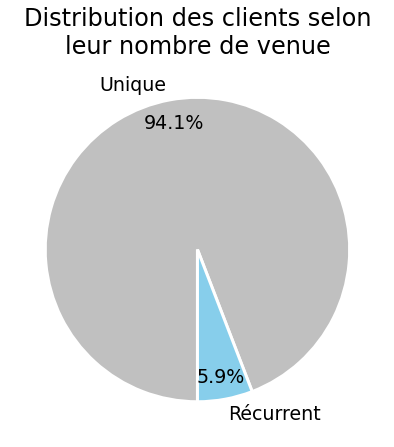

In [34]:
freq = []
freq.append((olist_rfm.loc[olist_rfm["frequency"]==1,"frequency"].count()*100/olist_rfm["frequency"].shape[0]))
freq.append((olist_rfm.loc[olist_rfm["frequency"]>1,"frequency"].count()*100/olist_rfm["frequency"].shape[0]))
label = ["Unique", "Récurrent"]
plt.figure(figsize=(7,7))
plt.pie(freq, labels=label, autopct='%1.1f%%', textprops={'color':"black", "fontsize" : "19"}, 
        pctdistance=0.85, labeldistance=1.1,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        colors = ["silver", "skyblue"], startangle=-90, counterclock=False)
plt.title("Distribution des clients selon\nleur nombre de venue", fontsize=24)
plt.show()

Nous voyons sur le graphique qu'il y a peu de commandes passées plus d'une fois par le même client.
Nous venons de créer la matrice RFM. Nous allons mettre l'ensemble des données à la même échelle et représenter chaque variable deux à deux. 

In [35]:
olist_rfm["monetary"] = np.log10(1 + olist_rfm["monetary"])
olist_rfm["recency"] = np.log10(1 + olist_rfm["recency"])
olist_rfm["frequency"] = np.log10(1 + olist_rfm["frequency"])

display(olist_rfm.describe())

,recency,frequency,monetary
count,93358.000000,93358.000000,93358.000000
mean,2.241512,0.313320,2.053844
std,0.408648,0.054397,0.351064
min,0.000000,0.301030,1.024896
25%,2.060698,0.301030,1.806587
50%,2.340444,0.301030,2.036549
75%,2.540329,0.301030,2.263772
max,2.853698,1.531479,4.135612


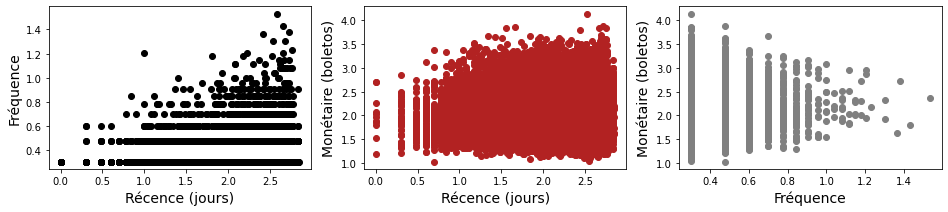

In [36]:
plt.figure(figsize=(16,3))

plt.subplot(131)
plt.scatter(olist_rfm["recency"], olist_rfm["frequency"], color="black")

plt.xlabel("Récence (jours)", fontsize=14)
plt.ylabel("Fréquence", fontsize=14)

plt.subplot(132)
plt.scatter(olist_rfm["recency"], olist_rfm["monetary"], color="firebrick")

plt.xlabel("Récence (jours)", fontsize=14)
plt.ylabel("Monétaire (boletos)", fontsize=14)

plt.subplot(133)
plt.scatter(olist_rfm["frequency"], olist_rfm["monetary"], color="gray")

plt.xlabel("Fréquence", fontsize=14)
plt.ylabel("Monétaire (boletos)", fontsize=14)

plt.show()

<a class="anchor" id="chapter2"></a>
# Création de la base client

Nous allons utiliser les différents fichiers mis à notre disposition pour en tirer le maximum d'information des clients. Nous allons commencer par les données liées aux moments où les commandes sont passées et reçues par le client.

<a class="anchor" id="section_2_1"></a>
## Données liées aux commandes

In [37]:
display(olist_2["payment_type"].value_counts())

credit_card    74586
boleto         19191
voucher         5493
debit_card      1486
Name: payment_type, dtype: int64

In [38]:
olist_2["heure"] = pd.to_datetime(olist_2["order_purchase_timestamp"]).dt.hour
olist_2["jour"] = pd.to_datetime(olist_2["order_purchase_timestamp"]).dt.day
olist_2["mois"] = pd.to_datetime(olist_2["order_purchase_timestamp"]).dt.month
olist_2["jour_semaine"] = pd.to_datetime(olist_2["order_purchase_timestamp"]).dt.weekday

olist_2["attente_commande"] = (olist_2.loc[olist_2["order_delivered_customer_date"].notnull(), 
                                           "order_delivered_customer_date"] - olist_2["order_purchase_timestamp"]).dt.days

olist_2["retard_commande"] = (olist_2["order_estimated_delivery_date"] - olist_2.loc[olist_2["order_delivered_customer_date"].notnull(), 
                                                                                     "order_delivered_customer_date"]).dt.days

olist_2["nbr_payment"] = olist_2[["customer_unique_id", 
                                  "payment_type"]].groupby(['customer_unique_id'])["payment_type"].transform('nunique')
olist_2["type_payment"] = olist_2[["customer_unique_id", 
                                   "payment_type"]].groupby(['customer_unique_id'])["payment_type"].transform('max')
display(olist_2["type_payment"].value_counts())
display(olist_2.info())

credit_card    72450
boleto         18927
voucher         7847
debit_card      1532
Name: type_payment, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100757 entries, 0 to 100756
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    100757 non-null  object        
 1   customer_unique_id             100757 non-null  object        
 2   customer_zip_code_prefix       100757 non-null  int64         
 3   customer_city                  100757 non-null  object        
 4   customer_state                 100757 non-null  object        
 5   order_id                       100757 non-null  object        
 6   order_status                   100757 non-null  object        
 7   order_purchase_timestamp       100757 non-null  datetime64[ns]
 8   order_approved_at              100743 non-null  datetime64[ns]
 9   order_delivered_carrier_date   100755 non-null  datetime64[ns]
 10  order_delivered_customer_date  100757 non-null  datetime64[ns]
 11  

None

In [39]:
olist_2.loc[(olist_2["retard_commande"].isna()) & (olist_2["order_status"]=="canceled"), "retard_commande"] = 0
olist_2.loc[(olist_2["retard_commande"].isna()) & (olist_2["order_status"]=="unavailable"), "retard_commande"] = 0

olist_2 = olist_2.loc[olist_2["nbr_payment"]!= 0,:]

In [40]:
display(olist_2["nbr_payment"].value_counts())

1    94776
2     5916
3       64
Name: nbr_payment, dtype: int64

Nous allons ajouter les notes attribuées par les clients sur leurs commandes passées.

In [41]:
olist_order_reviews_grouped = olist_order_reviews.groupby("order_id", as_index=False).agg({"review_score" : "mean"})

In [42]:
olist_3 = pd.merge(olist_2, olist_order_reviews_grouped, 
                   left_on= "order_id",
                   right_on= "order_id", 
                   how="left")
display(olist_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100756 entries, 0 to 100755
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    100756 non-null  object        
 1   customer_unique_id             100756 non-null  object        
 2   customer_zip_code_prefix       100756 non-null  int64         
 3   customer_city                  100756 non-null  object        
 4   customer_state                 100756 non-null  object        
 5   order_id                       100756 non-null  object        
 6   order_status                   100756 non-null  object        
 7   order_purchase_timestamp       100756 non-null  datetime64[ns]
 8   order_approved_at              100742 non-null  datetime64[ns]
 9   order_delivered_carrier_date   100754 non-null  datetime64[ns]
 10  order_delivered_customer_date  100756 non-null  datetime64[ns]
 11  

None

Certains scores sont manquants. Nous allons faire une imputation par la moyenne ou la médiane selon qu'il y ait des valuers extrêmes ou non.

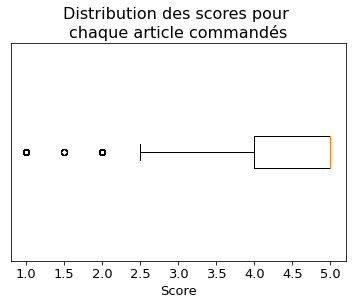

In [43]:
plt.boxplot(olist_3.loc[olist_3["review_score"].notnull(), "review_score"], vert=False)

plt.xlabel("Score", fontsize=13)

plt.xticks(fontsize=13)
plt.yticks([])

plt.title("Distribution des scores pour \nchaque article commandés", fontsize=16)
plt.show()

In [44]:
olist_3.loc[(olist_3["review_score"].isna()) & (olist_3["order_status"]=="delivered"), "review_score"] = 5

['credit_card', 'debit_card', 'voucher', 'boleto']


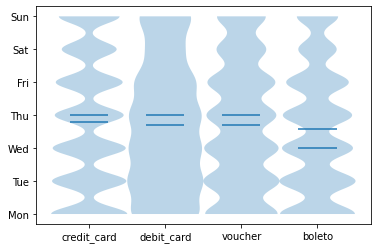

In [45]:
list_type_payment = olist_3.loc[(olist_3["type_payment"].notnull()) & (olist_3["jour_semaine"].notnull()), 
                                "type_payment"].unique().tolist()
print(list_type_payment)
data = []
for i in range (0, len(list_type_payment)):
    plot_data = olist_3.loc[(olist_3["type_payment"].notnull()) & (olist_3["jour_semaine"].notnull()) & 
                            (olist_3["type_payment"]==list_type_payment[i]), 
                            "jour_semaine"].tolist()
    data.append(plot_data)
    plot_data = []

plt.violinplot(data, positions = [1,3,5,7] , widths = 2, points = 1000, 
               showmeans = True,
               showextrema = False, 
               showmedians = True)

plt.xticks([1,3,5,7], labels = ['credit_card', 'debit_card', 'voucher', 'boleto'])
plt.yticks([0,1,2,3,4,5,6], labels = ['Mon', 'Tue', 'Wed', 'Thu', "Fri", "Sat", "Sun"])

plt.show()

In [46]:
#sns.stripplot(data = olist_3.sample(50000, random_state = 0), x = "mois", y = "payment_value")

#plt.show()

Nous allons maintenant chercher à comprendre quel type d'articles et combien d'articles les clients achètent en moyenne.
<a class="anchor" id="section_2_2"></a>
## Données sur les articles

Nous allons d'abord utiliser le fichier "olist_items" pour déterminer combien d'articles sont achetés pour chaque commande.

In [47]:
display(olist_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


None

In [48]:
olist_items["total_products"] = olist_items[["order_id", 
                                             "order_item_id"]].groupby("order_id")["order_item_id"].transform("max")

display(olist_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
 7   total_products       112650 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 6.9+ MB


None

En nous basant sur les fichiers "olist_products" et "olist_category_name", nous allons déterminer quelles catégories d'articles sont les plus demandées. De plus, nous allons déterminer quels sont les articles achetés selon leur volume.

In [49]:
olist_product_category = pd.merge(olist_products, olist_category_name, on="product_category_name", how="outer")
display(olist_product_category.info())

olist_item_prod = pd.merge(olist_items, olist_product_category, on="product_id", how="outer")

olist_item_prod["vol_product"] = olist_item_prod["product_length_cm"]*olist_item_prod["product_height_cm"]*olist_item_prod["product_width_cm"]
display(olist_item_prod.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32328 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   total_products                 112650 non-null  int64  
 8   product_category_name          111047 non-null  object 
 9   product_name_lenght            111047 non-null  float64
 10  product_description_lenght     111047 non-null  float64
 11  product_photos_qty             111047 non-null  float64
 12  product_weight_g              

None

In [50]:
olist_product_category.loc[olist_product_category["product_category_name_english"].isna(), 
                           "product_category_name_english"] = "unknown"
olist_item_prod.loc[olist_item_prod["product_category_name_english"].isna(), 
                    "product_category_name_english"] = "unknown"

In [51]:
olist_item_prod.loc[olist_item_prod["product_photos_qty"].isna(), "product_photos_qty"] = 0
display(olist_item_prod.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   total_products                 112650 non-null  int64  
 8   product_category_name          111047 non-null  object 
 9   product_name_lenght            111047 non-null  float64
 10  product_description_lenght     111047 non-null  float64
 11  product_photos_qty             112650 non-null  float64
 12  product_weight_g              

None

In [52]:
display((olist_item_prod["product_category_name_english"].unique()))

array(['cool_stuff', 'pet_shop', 'furniture_decor', 'perfumery',
       'garden_tools', 'housewares', 'telephony', 'health_beauty',
       'books_technical', 'fashion_bags_accessories', 'bed_bath_table',
       'sports_leisure', 'consoles_games', 'office_furniture',
       'luggage_accessories', 'food', 'agro_industry_and_commerce',
       'electronics', 'computers_accessories',
       'construction_tools_construction', 'audio', 'baby',
       'construction_tools_lights', 'toys', 'stationery',
       'industry_commerce_and_business', 'watches_gifts', 'auto',
       'unknown', 'home_appliances',
       'kitchen_dining_laundry_garden_furniture', 'air_conditioning',
       'home_confort', 'fixed_telephony',
       'small_appliances_home_oven_and_coffee', 'diapers_and_hygiene',
       'signaling_and_security', 'musical_instruments',
       'small_appliances', 'costruction_tools_garden', 'art',
       'home_construction', 'books_general_interest', 'party_supplies',
       'construction_tool

Au vu du nombre de catégorie d'articles, nous allons faire des groupes de catégories pour que la lecture des données soit plus lisible.

In [53]:
list_other = ["agro_industry_and_commerce", "industry_commerce_and_business", "security_and_services", 
              "signaling_and_security", "stationery", "construction_tools_construction", "construction_tools_lights", 
              "construction_tools_safety", "market_place", "pet_shop", "unknown"]

list_food = ["drinks", "food", "food_drink"]

list_clothes = ["fashio_female_clothing", "fashion_bags_accessories", "fashion_childrens_clothes", "fashion_male_clothing", 
                "fashion_shoes", "fashion_sport", "fashion_underwear_beach"]

list_house = ["housewares", "home_confort", "furniture_decor", "air_conditioning", "garden_tools", "bed_bath_table", 
              "costruction_tools_garden", "costruction_tools_tools", "furniture_bedroom", "furniture_living_room", 
              "furniture_mattress_and_upholstery", "home_appliances", "home_appliances_2", "home_comfort_2", 
              "home_construction", "kitchen_dining_laundry_garden_furniture", "la_cuisine", "office_furniture", "flowers", 
              "luggage_accessories"]

list_sport_leisure = ["sports_leisure", "toys", "art", "arts_and_craftmanship", "books_general_interest", "books_imported", 
                      "books_technical", "cds_dvds_musicals", "music", "musical_instruments", "cool_stuff", "watches_gifts", 
                      "christmas_supplies", "party_supplies", "tablets_printing_image"] 

list_electronics = ["computers_accessories", "telephony", "audio", "auto", "cine_photo", "computers", "consoles_games", 
                    "dvds_blu_ray", "electronics", "small_appliances", "small_appliances_home_oven_and_coffee", 
                    "fixed_telephony"]

list_health_body = ["health_beauty", "baby", "diapers_and_hygiene", "perfumery"]

for elt in list_other:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "Other"

for elt in list_food:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "Food"
    
for elt in list_clothes:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "Clothes"
    
for elt in list_house:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "House"
    
for elt in list_sport_leisure:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "Sport_leisure"
    
for elt in list_electronics:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "Electronics"

for elt in list_health_body:
    olist_item_prod.loc[olist_item_prod["product_category_name_english"]==elt,"category_objects"] = "Health_body"

In [54]:
display(olist_item_prod.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   total_products                 112650 non-null  int64  
 8   product_category_name          111047 non-null  object 
 9   product_name_lenght            111047 non-null  float64
 10  product_description_lenght     111047 non-null  float64
 11  product_photos_qty             112650 non-null  float64
 12  product_weight_g              

None

In [55]:
olist_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100756 entries, 0 to 100756
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    100756 non-null  object        
 1   customer_unique_id             100756 non-null  object        
 2   customer_zip_code_prefix       100756 non-null  int64         
 3   customer_city                  100756 non-null  object        
 4   customer_state                 100756 non-null  object        
 5   order_id                       100756 non-null  object        
 6   order_status                   100756 non-null  object        
 7   order_purchase_timestamp       100756 non-null  datetime64[ns]
 8   order_approved_at              100742 non-null  datetime64[ns]
 9   order_delivered_carrier_date   100754 non-null  datetime64[ns]
 10  order_delivered_customer_date  100756 non-null  datetime64[ns]
 11  

In [56]:
olist_item_prod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   total_products                 112650 non-null  int64  
 8   product_category_name          111047 non-null  object 
 9   product_name_lenght            111047 non-null  float64
 10  product_description_lenght     111047 non-null  float64
 11  product_photos_qty             112650 non-null  float64
 12  product_weight_g              

In [57]:
olist_product = pd.merge(olist_2[["customer_unique_id", "order_id"]], 
                         olist_item_prod[["category_objects", "total_products", "product_photos_qty", 
                                          "vol_product", "order_id"]], 
                         on="order_id", how="outer")
display(olist_product.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117491 entries, 0 to 117490
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  115035 non-null  object 
 1   order_id            117491 non-null  object 
 2   category_objects    117491 non-null  object 
 3   total_products      117491 non-null  int64  
 4   product_photos_qty  117491 non-null  float64
 5   vol_product         117471 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 6.3+ MB


None

Nous déterminons dans quelle catégorie d'article il y a le plus d'achat par client. 

In [58]:
olist_product = olist_product.loc[(olist_product["category_objects"].notnull()), :]
olist_product["nbr_category"] = olist_product[["customer_unique_id", 
                                               "category_objects"]].groupby(['customer_unique_id'])["category_objects"].transform('nunique')
olist_product["main_category"] = olist_product[["customer_unique_id", 
                                                "category_objects"]].groupby(['customer_unique_id'])["category_objects"].transform('max')
display(olist_product.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117491 entries, 0 to 117490
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  115035 non-null  object 
 1   order_id            117491 non-null  object 
 2   category_objects    117491 non-null  object 
 3   total_products      117491 non-null  int64  
 4   product_photos_qty  117491 non-null  float64
 5   vol_product         117471 non-null  float64
 6   nbr_category        115035 non-null  float64
 7   main_category       115035 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 8.1+ MB


None

In [59]:
olist_product["nbr_category"].value_counts()

1.0    110795
2.0      3942
3.0       251
4.0        47
Name: nbr_category, dtype: int64

In [60]:
olist_product_grouped = olist_product.groupby(['customer_unique_id'], as_index=False).agg({"total_products" : "mean", 
                                                                                           "main_category" : "max",
                                                                                           "nbr_category" : "mean",
                                                                                           "product_photos_qty" : "mean", 
                                                                                           "vol_product" : "mean"})

display(olist_product_grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93357 non-null  object 
 1   total_products      93357 non-null  float64
 2   main_category       93357 non-null  object 
 3   nbr_category        93357 non-null  float64
 4   product_photos_qty  93357 non-null  float64
 5   vol_product         93344 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.3+ MB


None

Nous allons maintenant essayer de savoir où les clients se situent ainsi que les vendeurs auprès desquels les clients achètent.
<a class="anchor" id="section_2_3"></a>
## Données liées à la géolocalisation

In [61]:
geolocation_compact = olist_geolocation.groupby("geolocation_zip_code_prefix", 
                                                as_index=False).agg({"geolocation_lat" : "mean", "geolocation_lng" : "mean", 
                                                                     "geolocation_city" : "max", "geolocation_state" : "max"})
                                                                     
display(geolocation_compact.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 742.9+ KB


None

In [62]:
olist_item_seller = pd.merge(olist_items, olist_sellers, on="seller_id", how="outer")
olist_geoloc_seller = pd.merge(olist_item_seller[["order_id", "seller_id", "seller_zip_code_prefix", "seller_city"]], 
                               geolocation_compact, 
                               left_on=["seller_zip_code_prefix"], 
                               right_on=["geolocation_zip_code_prefix"], 
                               how="left")

olist_geoloc_customer = pd.merge(olist_1, geolocation_compact, 
                                 left_on="customer_zip_code_prefix", 
                                 right_on="geolocation_zip_code_prefix", 
                                 how="left")

olist_geoloc_customer = olist_geoloc_customer.drop(columns=["order_status", "order_purchase_timestamp", "order_approved_at", 
                                                            "order_delivered_carrier_date", "order_delivered_carrier_date", 
                                                            "order_estimated_delivery_date", "order_delivered_customer_date",
                                                            ])

display(olist_geoloc_seller.info())
display(olist_geoloc_customer.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     112650 non-null  object 
 1   seller_id                    112650 non-null  object 
 2   seller_zip_code_prefix       112650 non-null  int64  
 3   seller_city                  112650 non-null  object 
 4   geolocation_zip_code_prefix  112397 non-null  float64
 5   geolocation_lat              112397 non-null  float64
 6   geolocation_lng              112397 non-null  float64
 7   geolocation_city             112397 non-null  object 
 8   geolocation_state            112397 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 8.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   customer_city                99441 non-null  object 
 4   customer_state               99441 non-null  object 
 5   order_id                     99441 non-null  object 
 6   geolocation_zip_code_prefix  99163 non-null  float64
 7   geolocation_lat              99163 non-null  float64
 8   geolocation_lng              99163 non-null  float64
 9   geolocation_city             99163 non-null  object 
 10  geolocation_state            99163 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 9.1+ MB


None

Nous voyons qu'il y a des valuers manquantes sur la géolocalisation des clients et des vendeurs. Nous allons faire des imputations de la latitude et la longitude en nous basant sur les codes postaux et si besoin par les villes.

In [63]:
display(olist_geoloc_seller.loc[olist_geoloc_seller["geolocation_zip_code_prefix"].isna(), 
                                ["seller_city"]].value_counts())

seller_city    
sao paulo          137
pocos de caldas     61
brasilia            42
curitiba             9
aruja                2
porto alegre         2
dtype: int64

In [64]:
list_city = olist_geoloc_seller.loc[olist_geoloc_seller["geolocation_zip_code_prefix"].isna(), 
                                    "seller_city"].unique().tolist()

for elt in list_city:
    mean_lat = olist_geolocation.loc[olist_geolocation["geolocation_city"]==elt,"geolocation_lat"].mean()
    mean_lng = olist_geolocation.loc[olist_geolocation["geolocation_city"]==elt,"geolocation_lng"].mean()
    
    olist_geoloc_seller.loc[(olist_geoloc_seller["geolocation_zip_code_prefix"].isna()) & 
                            (olist_geoloc_seller["seller_city"]==elt), "geolocation_lat"] = mean_lat
    olist_geoloc_seller.loc[(olist_geoloc_seller["geolocation_zip_code_prefix"].isna()) & 
                            (olist_geoloc_seller["seller_city"]==elt), "geolocation_lng"] = mean_lng
    mean_lat = []
    mean_lng = []

In [65]:
display(olist_geoloc_seller.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     112650 non-null  object 
 1   seller_id                    112650 non-null  object 
 2   seller_zip_code_prefix       112650 non-null  int64  
 3   seller_city                  112650 non-null  object 
 4   geolocation_zip_code_prefix  112397 non-null  float64
 5   geolocation_lat              112650 non-null  float64
 6   geolocation_lng              112650 non-null  float64
 7   geolocation_city             112397 non-null  object 
 8   geolocation_state            112397 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 8.6+ MB


None

In [66]:
display(olist_geoloc_customer.loc[olist_geoloc_customer["geolocation_zip_code_prefix"].isna(), 
                                  ["customer_zip_code_prefix"]].value_counts())

customer_zip_code_prefix
70686                       15
72005                       13
71919                       10
73255                        7
72300                        6
                            ..
55863                        1
55027                        1
49870                        1
48504                        1
95853                        1
Length: 157, dtype: int64

In [67]:
list_city = olist_geoloc_customer.loc[olist_geoloc_customer["geolocation_zip_code_prefix"].isna(), 
                                      "customer_city"].unique().tolist()

for elt in list_city:
    mean_lat = olist_geolocation.loc[olist_geolocation["geolocation_city"]==elt,"geolocation_lat"].mean()
    mean_lng = olist_geolocation.loc[olist_geolocation["geolocation_city"]==elt,"geolocation_lng"].mean()
    
    olist_geoloc_customer.loc[(olist_geoloc_customer["geolocation_zip_code_prefix"].isna()) & 
                              (olist_geoloc_customer["customer_city"]==elt), "geolocation_lat"] = mean_lat
    olist_geoloc_customer.loc[(olist_geoloc_customer["geolocation_zip_code_prefix"].isna()) & 
                              (olist_geoloc_customer["customer_city"]==elt), "geolocation_lng"] = mean_lng
    mean_lat = []
    mean_lng = []

display(olist_geoloc_customer.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   customer_city                99441 non-null  object 
 4   customer_state               99441 non-null  object 
 5   order_id                     99441 non-null  object 
 6   geolocation_zip_code_prefix  99163 non-null  float64
 7   geolocation_lat              99392 non-null  float64
 8   geolocation_lng              99392 non-null  float64
 9   geolocation_city             99163 non-null  object 
 10  geolocation_state            99163 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 9.1+ MB


None

In [68]:
display(olist_geoloc_customer.loc[olist_geoloc_customer["geolocation_lat"].isna(), 
                                ["customer_city", "customer_state", "customer_zip_code_prefix"]].value_counts())

customer_city                 customer_state  customer_zip_code_prefix
maioba                        MA              65137                       3
monnerat                      RJ              28655                       2
nossa senhora do remedio      SP              8980                        2
palmeirinha                   PR              85118                       2
santo eduardo                 RJ              28160                       2
domiciano ribeiro             GO              75784                       2
poco de pedra                 RN              59299                       1
palmital de minas             MG              38627                       1
passagem                      PB              58734                       1
perola independente           PR              85958                       1
pinhotiba                     MG              36857                       1
pitanga de estrada            PB              58286                       1
alto sao joao    

In [69]:
list_state = olist_geoloc_customer.loc[olist_geoloc_customer["geolocation_zip_code_prefix"].isna(), 
                                      "customer_state"].unique().tolist()

for elt in list_state:
    mean_lat = olist_geolocation.loc[olist_geolocation["geolocation_state"]==elt,"geolocation_lat"].mean()
    mean_lng = olist_geolocation.loc[olist_geolocation["geolocation_state"]==elt,"geolocation_lng"].mean()
    
    olist_geoloc_customer.loc[(olist_geoloc_customer["geolocation_zip_code_prefix"].isna()) & 
                              (olist_geoloc_customer["customer_state"]==elt), "geolocation_lat"] = mean_lat
    olist_geoloc_customer.loc[(olist_geoloc_customer["geolocation_zip_code_prefix"].isna()) & 
                              (olist_geoloc_customer["customer_state"]==elt), "geolocation_lng"] = mean_lng
    mean_lat = []
    mean_lng = []

display(olist_geoloc_customer.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   customer_city                99441 non-null  object 
 4   customer_state               99441 non-null  object 
 5   order_id                     99441 non-null  object 
 6   geolocation_zip_code_prefix  99163 non-null  float64
 7   geolocation_lat              99441 non-null  float64
 8   geolocation_lng              99441 non-null  float64
 9   geolocation_city             99163 non-null  object 
 10  geolocation_state            99163 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 9.1+ MB


None

Nous renommons les variables liées à la latitude et la longitude dans chaque fichier que nous venons de créer.

In [70]:
olist_geoloc_customer.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_lng"}, inplace=True)

olist_geoloc_seller = olist_geoloc_seller.rename(columns={"geolocation_lat" : "seller_lat", 
                                                  "geolocation_lng" : "seller_lng"})
olist_geoloc_seller = olist_geoloc_seller.drop(columns=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"])
display(olist_geoloc_seller.info())
display(olist_geoloc_customer.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                112650 non-null  object 
 1   seller_id               112650 non-null  object 
 2   seller_zip_code_prefix  112650 non-null  int64  
 3   seller_city             112650 non-null  object 
 4   seller_lat              112650 non-null  float64
 5   seller_lng              112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 6.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   customer_city                99441 non-null  object 
 4   customer_state               99441 non-null  object 
 5   order_id                     99441 non-null  object 
 6   geolocation_zip_code_prefix  99163 non-null  float64
 7   customer_lat                 99441 non-null  float64
 8   customer_lng                 99441 non-null  float64
 9   geolocation_city             99163 non-null  object 
 10  geolocation_state            99163 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 9.1+ MB


None

Nous fusionnons les données sur les clients et les vendeurs pour déterminer la distance entre les clients et les vendeurs.

In [71]:
olist_4 = pd.merge(olist_geoloc_seller, olist_geoloc_customer, on="order_id", how="outer")

display(olist_4.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     113425 non-null  object 
 1   seller_id                    112650 non-null  object 
 2   seller_zip_code_prefix       112650 non-null  float64
 3   seller_city                  112650 non-null  object 
 4   seller_lat                   112650 non-null  float64
 5   seller_lng                   112650 non-null  float64
 6   customer_id                  113425 non-null  object 
 7   customer_unique_id           113425 non-null  object 
 8   customer_zip_code_prefix     113425 non-null  int64  
 9   customer_city                113425 non-null  object 
 10  customer_state               113425 non-null  object 
 11  geolocation_zip_code_prefix  113119 non-null  float64
 12  customer_lat                 113425 non-null  float64
 13 

None

Nous créeons une fonction pour calculer la distance entre les clients et les vendeurs en nous basant sur la géolocalisation et la distance haversine.

In [72]:
def haversine_vectorize(lon1, lat1, lon2, lat2):
    """Returns distance, in kilometers, between one set of longitude/latitude coordinates and another"""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
 
    newlon = lon2 - lon1
    newlat = lat2 - lat1
 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [73]:
olist_4["distance_seller_customer"] = haversine_vectorize(olist_4.loc[olist_4["customer_lng"].notnull(), "customer_lng"], 
                                                          olist_4.loc[olist_4["customer_lat"].notnull(), "customer_lat"], 
                                                          olist_4.loc[olist_4["seller_lng"].notnull(), "seller_lng"], 
                                                          olist_4.loc[olist_4["seller_lat"].notnull(), "seller_lat"])
olist_4["distance_seller_customer"] = olist_4["distance_seller_customer"].round(3)

In [74]:
display(olist_4.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     113425 non-null  object 
 1   seller_id                    112650 non-null  object 
 2   seller_zip_code_prefix       112650 non-null  float64
 3   seller_city                  112650 non-null  object 
 4   seller_lat                   112650 non-null  float64
 5   seller_lng                   112650 non-null  float64
 6   customer_id                  113425 non-null  object 
 7   customer_unique_id           113425 non-null  object 
 8   customer_zip_code_prefix     113425 non-null  int64  
 9   customer_city                113425 non-null  object 
 10  customer_state               113425 non-null  object 
 11  geolocation_zip_code_prefix  113119 non-null  float64
 12  customer_lat                 113425 non-null  float64
 13 

None

Nous déterminons pour chaque client la distance moyenne qui les sépare des vendeurs

In [75]:
colonne = ["customer_unique_id", "distance_seller_customer"]
olist_4_grouped = olist_4[colonne].groupby("customer_unique_id", as_index=False).agg({"distance_seller_customer" : "mean"})
display(olist_4_grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        96096 non-null  object 
 1   distance_seller_customer  95420 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


None

Dans les différentes parties présentées plus haut, nous avons isoler et/ou créer des variables liées aux clients mais celles-ci sont éparpillées entre plusieurs fichiers. Nous allons donc fusionner l'ensemble des données.
<a class="anchor" id="section_2_4"></a>
## Fusion des données
<a class="anchor" id="section_2_4_1"></a>
### Données clustering

In [76]:
display(olist_product_grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93357 non-null  object 
 1   total_products      93357 non-null  float64
 2   main_category       93357 non-null  object 
 3   nbr_category        93357 non-null  float64
 4   product_photos_qty  93357 non-null  float64
 5   vol_product         93344 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.3+ MB


None

In [77]:
display(olist_rfm.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93358 non-null  object 
 1   recency             93358 non-null  float64
 2   frequency           93358 non-null  float64
 3   monetary            93358 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.8+ MB


None

In [78]:
display(olist_4_grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        96096 non-null  object 
 1   distance_seller_customer  95420 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


None

In [79]:
display(olist_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100756 entries, 0 to 100755
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    100756 non-null  object        
 1   customer_unique_id             100756 non-null  object        
 2   customer_zip_code_prefix       100756 non-null  int64         
 3   customer_city                  100756 non-null  object        
 4   customer_state                 100756 non-null  object        
 5   order_id                       100756 non-null  object        
 6   order_status                   100756 non-null  object        
 7   order_purchase_timestamp       100756 non-null  datetime64[ns]
 8   order_approved_at              100742 non-null  datetime64[ns]
 9   order_delivered_carrier_date   100754 non-null  datetime64[ns]
 10  order_delivered_customer_date  100756 non-null  datetime64[ns]
 11  

None

In [80]:
colonne = ["customer_unique_id", "review_score", "heure", "jour_semaine", "jour", "mois", "attente_commande", "retard_commande",
           "nbr_payment", "type_payment", "payment_sequential", "payment_installments", "order_purchase_timestamp"]

olist_3_grouped = olist_3[colonne].groupby("customer_unique_id", as_index=False).agg({"review_score" : "mean", 
                                                                                      "heure" : "mean", 
                                                                                      "jour_semaine" : "mean", 
                                                                                      "jour" : "mean", 
                                                                                      "mois" : "mean", 
                                                                                      "attente_commande" : "mean", 
                                                                                      "retard_commande" : "mean", 
                                                                                      "payment_installments" : "mean",
                                                                                      "nbr_payment" : "mean", 
                                                                                      "type_payment" : "max", 
                                                                                      "order_purchase_timestamp" : "mean"})

display(olist_3_grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        93357 non-null  object        
 1   review_score              93357 non-null  float64       
 2   heure                     93357 non-null  float64       
 3   jour_semaine              93357 non-null  float64       
 4   jour                      93357 non-null  float64       
 5   mois                      93357 non-null  float64       
 6   attente_commande          93357 non-null  float64       
 7   retard_commande           93357 non-null  float64       
 8   payment_installments      93357 non-null  float64       
 9   nbr_payment               93357 non-null  float64       
 10  type_payment              93357 non-null  object        
 11  order_purchase_timestamp  93357 non-null  datetime64[ns]
dtypes: datetime64[ns](

None

In [81]:
olist_grouped_1 = pd.merge(olist_rfm, olist_3_grouped, on="customer_unique_id", how="left")
display(olist_grouped_1.shape)
olist_grouped_2 = pd.merge(olist_grouped_1, olist_4_grouped, on="customer_unique_id", how="left")
display(olist_grouped_2.shape)
olist_final = pd.merge(olist_grouped_2, olist_product_grouped , on="customer_unique_id", how="left")
display(olist_final.shape)
display(olist_final.info())

(93358, 15)

(93358, 16)

(93358, 21)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        93358 non-null  object        
 1   recency                   93358 non-null  float64       
 2   frequency                 93358 non-null  float64       
 3   monetary                  93358 non-null  float64       
 4   review_score              93357 non-null  float64       
 5   heure                     93357 non-null  float64       
 6   jour_semaine              93357 non-null  float64       
 7   jour                      93357 non-null  float64       
 8   mois                      93357 non-null  float64       
 9   attente_commande          93357 non-null  float64       
 10  retard_commande           93357 non-null  float64       
 11  payment_installments      93357 non-null  float64       
 12  nbr_payment       

None

In [82]:
colonne = ['heure', "review_score", 'jour_semaine', 'jour', 'mois', 'nbr_payment', "payment_installments", 
           'total_products', 'product_photos_qty', "nbr_category"]
olist_final[colonne] = olist_final[colonne].round(0)

In [83]:
display(olist_final.describe())

,recency,frequency,monetary,review_score,heure,jour_semaine,jour,mois,attente_commande,retard_commande,payment_installments,nbr_payment,distance_seller_customer,total_products,nbr_category,product_photos_qty,vol_product
count,93358.000000,93358.000000,93358.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93357.000000,93358.000000,93357.000000,93357.000000,93357.000000,93344.000000
mean,2.241512,0.313320,2.053844,4.158456,14.785030,2.755487,15.514541,6.032745,12.103137,10.848182,2.900832,1.026222,602.418547,1.142560,1.017738,2.226560,15178.112390
std,0.408648,0.054397,0.351064,1.277707,5.295261,1.958762,8.616083,3.213787,9.550740,10.137034,2.676020,0.160731,593.120125,0.534868,0.137874,1.743507,23165.214184
min,0.000000,0.301030,1.024896,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-189.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,168.000000
25%,2.060698,0.301030,1.806587,4.000000,11.000000,1.000000,8.000000,3.000000,6.000000,6.000000,1.000000,1.000000,191.404750,1.000000,1.000000,1.000000,2850.000000
50%,2.340444,0.301030,2.036549,5.000000,15.000000,3.000000,15.000000,6.000000,10.000000,11.000000,2.000000,1.000000,435.885000,1.000000,1.000000,2.000000,6525.000000
75%,2.540329,0.301030,2.263772,5.000000,19.000000,4.000000,23.000000,8.000000,15.000000,16.000000,4.000000,1.000000,800.612500,1.000000,1.000000,3.000000,18362.000000
max,2.853698,1.531479,4.135612,5.000000,23.000000,6.000000,31.000000,12.000000,209.000000,146.000000,24.000000,3.000000,8672.469000,21.000000,4.000000,20.000000,296208.000000


In [84]:
olist_final["nan"] = olist_final.iloc[:,:19].isna().sum(axis=1)/olist_final.iloc[:,:19].shape[1]
olist_final = olist_final.loc[olist_final["nan"]==0,:]
olist_final = olist_final.drop(columns="nan").reset_index(drop=True)
display(olist_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        93357 non-null  object        
 1   recency                   93357 non-null  float64       
 2   frequency                 93357 non-null  float64       
 3   monetary                  93357 non-null  float64       
 4   review_score              93357 non-null  float64       
 5   heure                     93357 non-null  float64       
 6   jour_semaine              93357 non-null  float64       
 7   jour                      93357 non-null  float64       
 8   mois                      93357 non-null  float64       
 9   attente_commande          93357 non-null  float64       
 10  retard_commande           93357 non-null  float64       
 11  payment_installments      93357 non-null  float64       
 12  nbr_payment       

None

Nous allons créer de nouvelles variables catégorielles nous indiquant quand les commandes sont effectuées. Nous allons nous baser sur les heures, les jours de la semaine, les jours du mois et les mois pour savoir si une commande est passée pendant les heures ouvrées ou non, les jours ouvrées ou non, la première ou deuxième quinzaine du mois, le trimestre de l'année et la période de l'année (scolaire ou vacances).

In [85]:
olist_final.loc[(olist_final["heure"]<18) & (olist_final["heure"]>=7) , "heure_commande"] = "Working_hours"
olist_final.loc[(olist_final["heure"]>=18) | (olist_final["heure"]<7), "heure_commande"] = "Resting_hours"

olist_final.loc[olist_final["jour_semaine"]>=5, "work_weekend"] = "Weekend"
olist_final.loc[olist_final["jour_semaine"]<5, "work_weekend"] = "Working_days"

olist_final.loc[olist_final["jour"]<16, "jour_commande"] = "1st_forstnight"
olist_final.loc[olist_final["jour"]>=16, "jour_commande"] = "2nd_forstnight"

olist_final.loc[olist_final["mois"]<4, "mois_commande"] = "1st_quarter"
olist_final.loc[(olist_final["mois"]<7) & (olist_final["mois"]>=4) , "mois_commande"] = "2nd_quarter"
olist_final.loc[(olist_final["mois"]<10) & (olist_final["mois"]>=7) , "mois_commande"] = "3rd_quarter"
olist_final.loc[olist_final["mois"]>=10, "mois_commande"] = "4th_quarter"

olist_final.loc[(olist_final["mois"]==12) | (olist_final["mois"]==1) | 
                (olist_final["mois"]==6) | (olist_final["mois"]==7), "holidays"] = "Yes"
olist_final.loc[(olist_final["mois"]!=12) & (olist_final["mois"]!=1) & 
                (olist_final["mois"]!=6) & (olist_final["mois"]!=7), "holidays"] = "No"

In [86]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

X_object = olist_final[["type_payment", "main_category", "heure_commande", "work_weekend", 
                        "jour_commande", "mois_commande", "holidays"]]
ohe.fit(X_object)

codes = ohe.transform(X_object).toarray()
feature_names = ohe.get_feature_names_out(["type_payment", "main_category", "heure_commande", "work_weekend", 
                                           "jour_commande", "mois_commande", "holidays"])

colonne = ["customer_unique_id", "order_purchase_timestamp", "recency", "frequency", "monetary", "total_products", 
           "nbr_category", "nbr_payment",  "payment_installments", "heure", "jour_semaine", "jour", "mois", 
           "attente_commande", "retard_commande", "distance_seller_customer", "product_photos_qty", "review_score", 
           "vol_product"]

data_olist = pd.concat([olist_final[colonne], 
               pd.DataFrame(codes, columns = feature_names).astype(int)], axis=1)

display(data_olist.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93357 entries, 0 to 93356
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_unique_id            93357 non-null  object        
 1   order_purchase_timestamp      93357 non-null  datetime64[ns]
 2   recency                       93357 non-null  float64       
 3   frequency                     93357 non-null  float64       
 4   monetary                      93357 non-null  float64       
 5   total_products                93357 non-null  float64       
 6   nbr_category                  93357 non-null  float64       
 7   nbr_payment                   93357 non-null  float64       
 8   payment_installments          93357 non-null  float64       
 9   heure                         93357 non-null  float64       
 10  jour_semaine                  93357 non-null  float64       
 11  jour                        

None

La base client vient d'être créee. Nous allons étudier cette base en faisant des analyses univariées, bivariées et multivariées.
<a class="anchor" id="chapter3"></a>
# Chapitre 3 : Analyse des données
<a class="anchor" id="section_3_1"></a>
## Analyse univariée

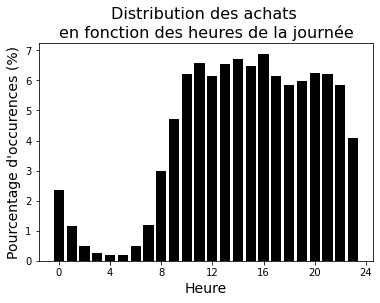

In [87]:
liste_heure = sorted(data_olist["heure"].unique().tolist())
y_max = data_olist["heure"].shape[0]
y_graph = []

for elt in liste_heure:
    y = []
    y = data_olist.loc[data_olist["heure"]==elt,"heure"].value_counts()
    y = float(y)*100/y_max
    y_graph.append(y)
plt.bar(height = y_graph, x = liste_heure, color="black")

plt.xlabel("Heure", fontsize = 14)
plt.ylabel("Pourcentage d'occurences (%)", fontsize = 14)

plt.xticks([0, 4, 8, 12, 16, 20, 24])
plt.title("Distribution des achats \nen fonction des heures de la journée", fontsize = 16)

plt.show()

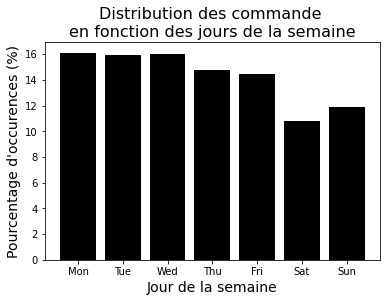

In [88]:
liste_jour_semaine = sorted(data_olist["jour_semaine"].unique().tolist())
y_max = data_olist["jour_semaine"].shape[0]
y_graph = []
liste_semaine = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for elt in liste_jour_semaine:
    y = []
    y = data_olist.loc[data_olist["jour_semaine"]==elt,"jour_semaine"].value_counts()
    y = float(y)*100/y_max
    y_graph.append(y)
    
plt.bar(height = y_graph, x = liste_semaine, color="black")

plt.xlabel("Jour de la semaine", fontsize = 14)
plt.ylabel("Pourcentage d'occurences (%)", fontsize = 14)

plt.title("Distribution des commande \nen fonction des jours de la semaine", fontsize = 16)

plt.show()

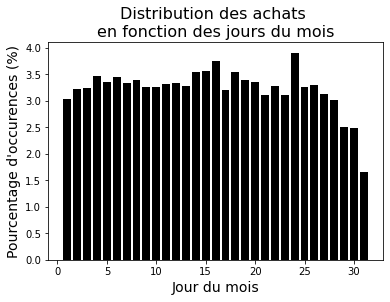

In [89]:
liste_jour = sorted(data_olist["jour"].unique().tolist())
y_max = data_olist["jour"].shape[0]
y_graph = []

for elt in liste_jour:
    y = []
    y = data_olist.loc[data_olist["jour"]==elt,"jour"].value_counts()
    y = float(y)*100/y_max
    y_graph.append(y)
plt.bar(height = y_graph, x = liste_jour, color="black")

plt.xlabel("Jour du mois", fontsize = 14)
plt.ylabel("Pourcentage d'occurences (%)", fontsize = 14)

plt.title("Distribution des achats \nen fonction des jours du mois", fontsize = 16)

plt.show()

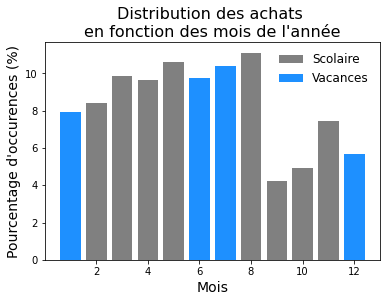

In [98]:
liste_mois = sorted(data_olist["mois"].unique().tolist())
y_max = data_olist["mois"].shape[0]
y_graph_work = []
y_graph_holid = []

for elt in liste_mois:
    if (elt!=1) &  (elt!=6) &(elt!=7) & (elt!=12):
        y = []
        y = data_olist.loc[data_olist["mois"]==elt,"mois"].value_counts()
        y = float(y)*100/y_max
        y_graph_work.append(y)
    else:
        y = []
        y = data_olist.loc[data_olist["mois"]==elt,"mois"].value_counts()
        y = float(y)*100/y_max
        y_graph_holid.append(y)

liste_mois_holidays = [1, 6, 7, 12]
liste_mois_work = [2, 3, 4, 5, 8, 9, 10 , 11]

plt.bar(height = y_graph_work, x = liste_mois_work, color="gray", label="Scolaire")
plt.bar(height = y_graph_holid, x = liste_mois_holidays, color="dodgerblue", label="Vacances")

plt.xlabel("Mois", fontsize = 14)
plt.ylabel("Pourcentage d'occurences (%)", fontsize = 14)

plt.title("Distribution des achats \nen fonction des mois de l'année", fontsize = 16)

plt.legend(frameon=False, fontsize=12)
plt.show()

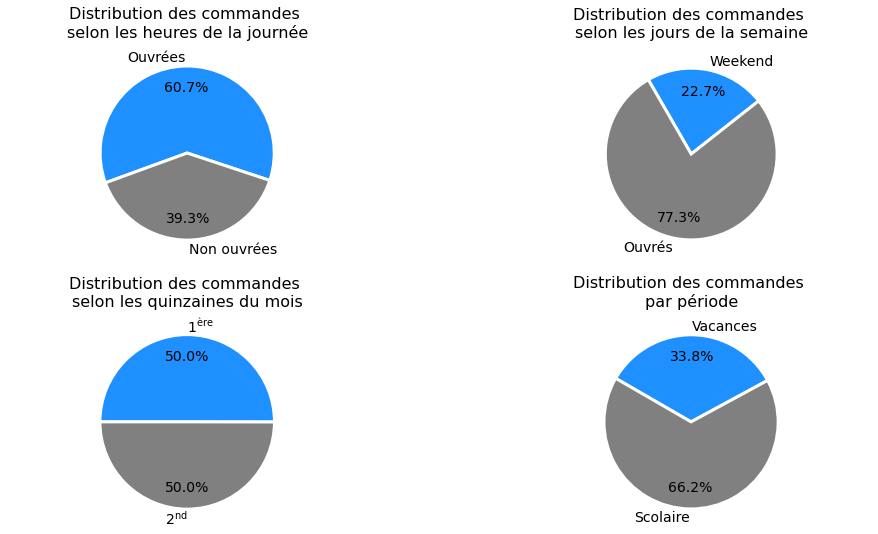

In [99]:
tot = olist_final.shape[1]

val_work_hours = len(olist_final.loc[olist_final["heure_commande"] == "Working_hours", 
                                     "heure_commande"].values.tolist())*100/tot
val_evening = len(olist_final.loc[olist_final["heure_commande"] == "Resting_hours", 
                                  "heure_commande"].values.tolist())*100/tot

val_day = [val_work_hours, val_evening]

day = ["Ouvrées", "Non ouvrées"]

val_weekend = len(olist_final.loc[olist_final["work_weekend"] == "Weekend", "work_weekend"].values.tolist())*100/tot
val_work_days = len(olist_final.loc[olist_final["work_weekend"] == "Working_days", "work_weekend"].values.tolist())*100/tot


val_semaine = [val_weekend, val_work_days]

semaine = ["Weekend", "Ouvrés"]

val_1st_week = len(olist_final.loc[olist_final["jour_commande"] == "1st_forstnight", 
                                   "jour_commande"].values.tolist())*100/tot
val_2nd_week = len(olist_final.loc[olist_final["jour_commande"] == "2nd_forstnight", 
                                   "jour_commande"].values.tolist())*100/tot

val_mois = [val_1st_week, val_2nd_week]

mois = [r"$1^{\rm ère}$", r"$2^{\rm nd}$"]

val_yes = len(olist_final.loc[olist_final["holidays"] == "Yes", "holidays"].values.tolist())*100/tot
val_no = len(olist_final.loc[olist_final["holidays"] == "No", "holidays"].values.tolist())*100/tot


val_trim = [val_yes, val_no]

trim = ["Vacances", "Scolaire"]


plt.figure(figsize=(15,8))
plt.subplot(221)

plt.pie(val_day, labels=day, autopct='%1.1f%%', textprops={'color':"black", "fontsize" : "14"}, 
        pctdistance=0.75, labeldistance=1.1,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        colors = ["dodgerblue", "gray", "indianred", "green"],
        startangle=200, counterclock=False)

plt.axis("equal")

plt.title("Distribution des commandes \nselon les heures de la journée", fontsize=16, pad=20)

plt.subplot(222)

plt.pie(val_semaine, labels=semaine, autopct='%1.1f%%', textprops={'color':"black", "fontsize" : "14"}, 
        pctdistance=0.75, labeldistance=1.1,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        colors = ["dodgerblue", "gray", "indianred", "green", "purple", "goldenrod", "dodgerblue", "crimson"],
        startangle=120, counterclock=False)

plt.axis("equal")

plt.title("Distribution des commandes \nselon les jours de la semaine", fontsize=16, pad=20)

plt.subplot(223)

plt.pie(val_mois, labels=mois, autopct='%1.1f%%', textprops={'color':"black", "fontsize" : "14"}, 
        pctdistance=0.75, labeldistance=1.1,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        colors = ["dodgerblue", "gray", "indianred"], 
        startangle=180, counterclock=False)

plt.axis("equal")

plt.title("Distribution des commandes \nselon les quinzaines du mois", fontsize=16, pad=20)

plt.subplot(224)

plt.pie(val_trim, labels=trim, autopct='%1.1f%%', textprops={'color':"black", "fontsize" : "14"}, 
        pctdistance=0.75, labeldistance=1.1,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        colors = ["dodgerblue", "gray", "indianred", "green"], startangle=150, counterclock=False)

plt.axis("equal")

plt.title("Distribution des commandes \npar période", fontsize=16, pad=20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

Nous voyons que les commandes sont passées majoritairement :
- pendant les heures ouvrées,
- pendant les jours ouvrés,
- pendant la période scolaire.

Nous allons déterminer s'il y a des moyens de paiements préférentiels et s'il y a des catégories d'articles plus demandés que d'autres.

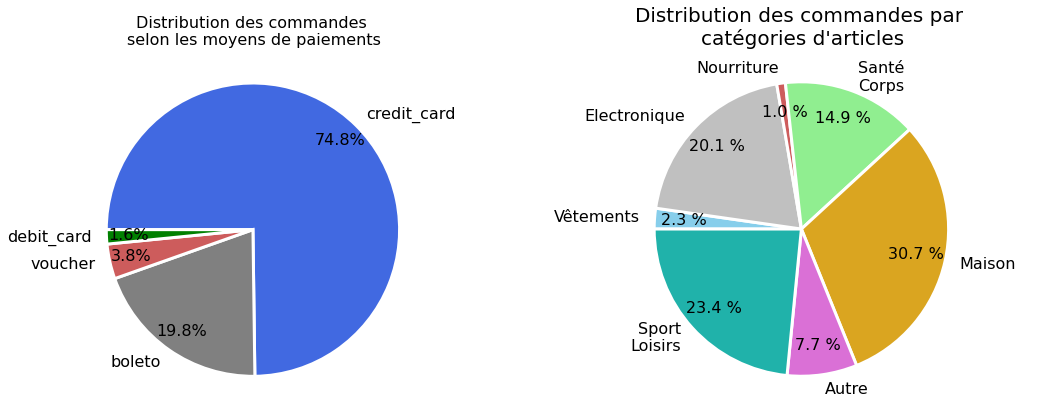

In [100]:
tot = len(olist_final.loc[olist_final["type_payment"].notnull(), "type_payment"].values.tolist())
list_type_payment = olist_final.loc[olist_final["type_payment"].notnull(), "type_payment"].unique().tolist()
val_type_payment = []

for elt in list_type_payment:
    val = len(olist_final.loc[olist_final["type_payment"] == elt, "type_payment"].values.tolist())*100/tot
    val_type_payment.append(val)
    val = []

tot = len(olist_final.loc[olist_final["main_category"].notnull(), "main_category"].values.tolist())
list_cat = sorted(olist_final.loc[olist_final["main_category"].notnull(), "main_category"].unique().tolist())
val_category = []

list_cat_simple = ["Vêtements", "Electronique", "Nourriture", "Santé\nCorps", "Maison", "Autre", "Sport\nLoisirs"]

for elt in list_cat:
    val = len(olist_final.loc[olist_final["main_category"] == elt, "main_category"].values.tolist())*100/tot
    val_category.append(val)
    val = []
    

plt.figure(figsize=(18,6))

plt.subplot(121)

plt.pie(val_type_payment, labels=list_type_payment, autopct='%1.1f%%', textprops={'color':"black", "fontsize" : "16"}, 
        pctdistance=0.85, labeldistance=1.1,
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        colors = ["royalblue", "gray", "indianred", "green"],
        startangle=180, counterclock=False)

plt.axis("equal")

plt.title("Distribution des commandes \nselon les moyens de paiements", fontsize=16, pad=20)

plt.subplot(122)

plt.pie(val_category, labels = list_cat_simple, autopct='%1.1f %%', textprops={'color':"black", "fontsize" : "16"}, 
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        pctdistance=0.8, labeldistance=1.1,
        explode = (0, 0, 0, 0, 0, 0, 0),
        colors = ["skyblue", "silver", "indianred", "lightgreen", "goldenrod", "orchid", "lightseagreen"], 
        startangle=180, counterclock=False)

plt.axis("equal")

plt.title("Distribution des commandes par \ncatégories d'articles", fontsize=20, pad=20)

plt.show()

Nous voyons que les commandes sont majoritairement payés en carte de crédit, puis en espèces.
De plus nous voyons que les clients achétent principalement des articles de maisons, de sport/loisirs, d'électronique et de produit de soin/beauté.

Nous allons étudier la dispersion des données numériques afin de supprimer de possibles valeurs extrêmes.

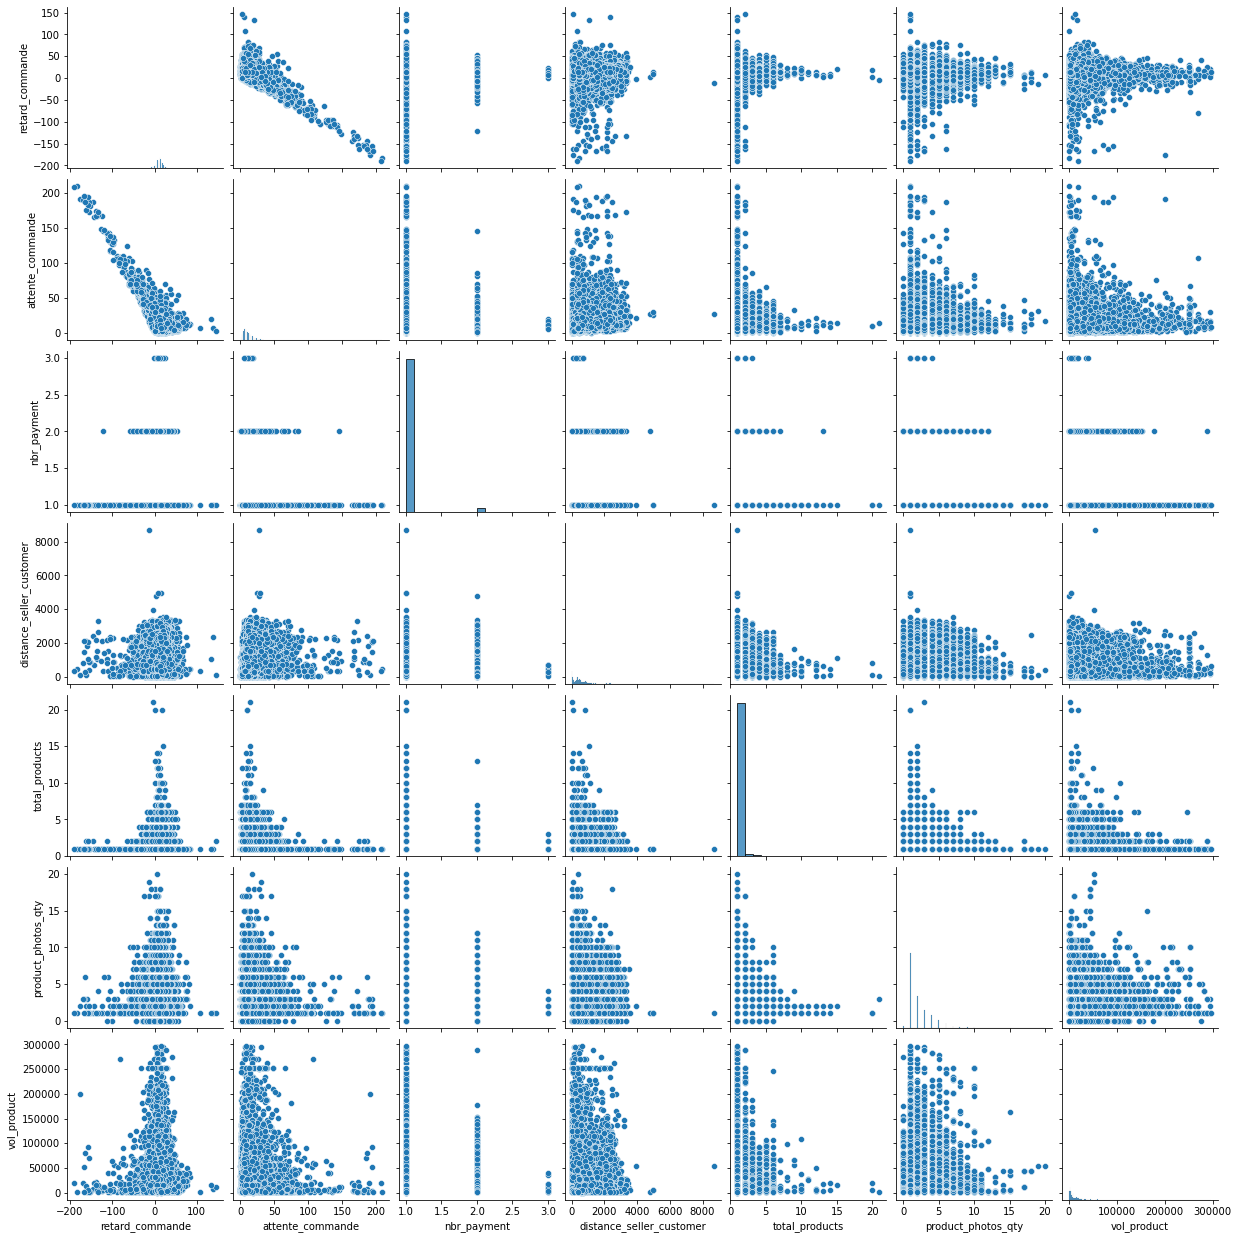

In [93]:
col = ["retard_commande", 'attente_commande', 'nbr_payment', 'distance_seller_customer', 'total_products', 
       'product_photos_qty', 'vol_product']

sns.pairplot(data_olist[col])
plt.show()

In [101]:
customer_to_remove = data_olist.loc[(data_olist["distance_seller_customer"]>8000) | 
                              (data_olist["total_products"]>18),"customer_unique_id"]

data_olist = data_olist.loc[(data_olist["distance_seller_customer"]<8000) & 
                              (data_olist["total_products"]<18),:].reset_index(drop=True)


display(data_olist.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93353 entries, 0 to 93352
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_unique_id            93353 non-null  object        
 1   order_purchase_timestamp      93353 non-null  datetime64[ns]
 2   recency                       93353 non-null  float64       
 3   frequency                     93353 non-null  float64       
 4   monetary                      93353 non-null  float64       
 5   total_products                93353 non-null  float64       
 6   nbr_category                  93353 non-null  float64       
 7   nbr_payment                   93353 non-null  float64       
 8   payment_installments          93353 non-null  float64       
 9   heure                         93353 non-null  float64       
 10  jour_semaine                  93353 non-null  float64       
 11  jour                        

None

In [102]:
colonne_log = data_olist.iloc[:,5:].columns.drop(["retard_commande"])

for col in colonne_log:
    data_olist[col] = np.log10(1 + data_olist[col])
data_olist["retard_commande"] = np.log10(190 + data_olist["retard_commande"])
display(data_olist.describe())

,recency,frequency,monetary,total_products,nbr_category,nbr_payment,payment_installments,heure,jour_semaine,jour,...,work_weekend_Weekend,work_weekend_Working_days,jour_commande_1st_forstnight,jour_commande_2nd_forstnight,mois_commande_1st_quarter,mois_commande_2nd_quarter,mois_commande_3rd_quarter,mois_commande_4th_quarter,holidays_No,holidays_Yes
count,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,...,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000,93353.000000
mean,2.241504,0.313321,2.053814,0.323212,0.304115,0.305640,0.512197,1.153786,0.499018,1.132793,...,0.068388,0.232642,0.150594,0.150436,0.078946,0.090383,0.077433,0.054267,0.199386,0.101644
std,0.408646,0.054398,0.351021,0.072204,0.023700,0.028217,0.246968,0.245485,0.276560,0.305738,...,0.126135,0.126135,0.150516,0.150516,0.132411,0.137982,0.131583,0.115721,0.142361,0.142361
min,0.000000,0.301030,1.024896,0.301030,0.301030,0.301030,0.000000,0.000000,0.000000,0.301030,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.060698,0.301030,1.806519,0.301030,0.301030,0.301030,0.301030,1.079181,0.301030,0.954243,...,0.000000,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.340444,0.301030,2.036549,0.301030,0.301030,0.301030,0.477121,1.204120,0.602060,1.204120,...,0.000000,0.301030,0.301030,0.000000,0.000000,0.000000,0.000000,0.000000,0.301030,0.000000
75%,2.540329,0.301030,2.263731,0.301030,0.301030,0.301030,0.698970,1.301030,0.698970,1.380211,...,0.000000,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030,0.000000,0.301030,0.301030
max,2.842609,1.531479,4.135612,1.204120,0.698970,0.602060,1.397940,1.380211,0.845098,1.505150,...,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030,0.301030


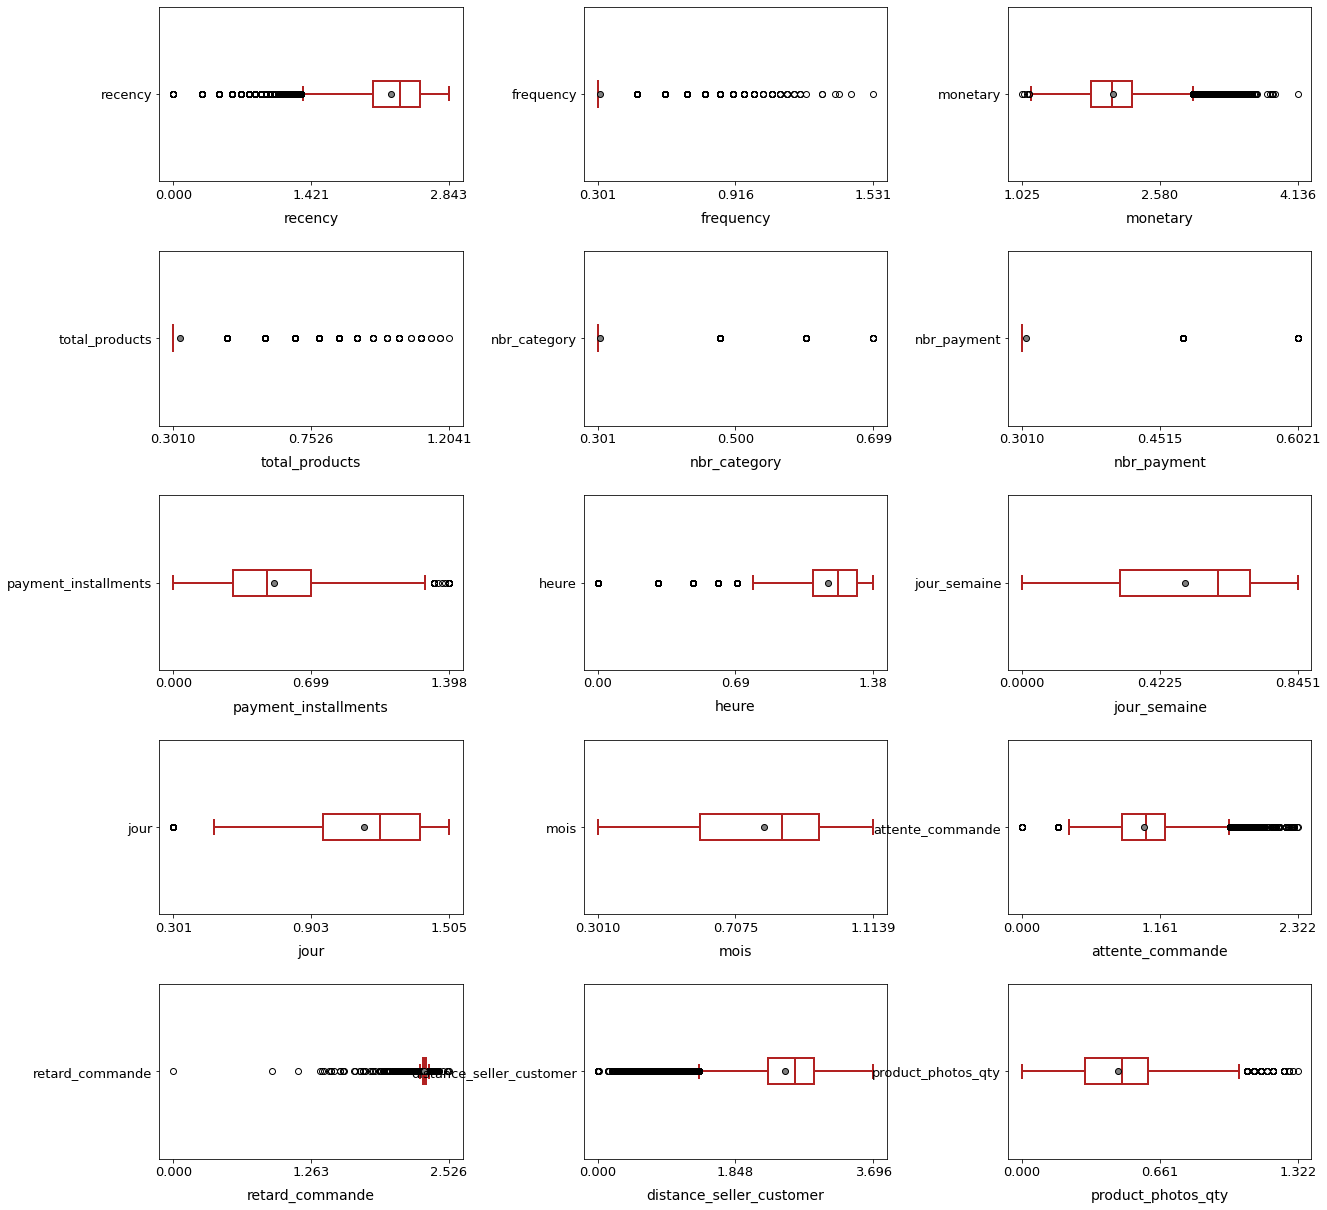

In [103]:
col = data_olist.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(20,20))
for i in range (0,15,1):
    plt.subplot(5,3,i+1)
    plt.boxplot(data_olist.loc[data_olist[col[i]].notnull(), col[i]], vert=False, showfliers=True, patch_artist=True, 
                capprops=dict(color="firebrick", linewidth=2),
                boxprops=dict(facecolor="white", color="firebrick", linewidth=2),
                whiskerprops=dict(color="firebrick", linewidth=2),
                medianprops=dict(color="firebrick", linewidth=2),
                showmeans=True, 
                meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'gray'})
    
    plt.yticks([1], labels=[col[i]], fontsize=13)
    mi = min(data_olist[col[i]])
    ma = max(data_olist[col[i]])
    moy = (mi+ma)/2
    ticks = [mi, moy, ma]
    plt.xticks(ticks, fontsize=13)
    plt.xlabel(f"{col[i]}", fontsize=14, labelpad=10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [104]:
display(data_olist.loc[data_olist["retard_commande"]<1.2,:])
customer_to_remove_2 = data_olist.loc[data_olist["retard_commande"]<1.2,"customer_unique_id"].values.tolist()
display(customer_to_remove, customer_to_remove_2)

,customer_unique_id,order_purchase_timestamp,recency,frequency,monetary,total_products,nbr_category,nbr_payment,payment_installments,heure,...,work_weekend_Weekend,work_weekend_Working_days,jour_commande_1st_forstnight,jour_commande_2nd_forstnight,mois_commande_1st_quarter,mois_commande_2nd_quarter,mois_commande_3rd_quarter,mois_commande_4th_quarter,holidays_No,holidays_Yes
27091,4a2519b6991378f6f2ce5ed22d308f03,2017-02-21 23:31:27,2.744293,0.30103,2.392134,0.30103,0.30103,0.30103,0.301030,1.380211,...,0.0,0.30103,0.00000,0.30103,0.30103,0.0,0.0,0.0,0.30103,0.00000
28014,4cb8ad9a4554099db7d70c13d0dae906,2018-01-03 09:44:01,2.378398,0.30103,2.657371,0.30103,0.30103,0.30103,0.845098,1.000000,...,0.0,0.30103,0.30103,0.00000,0.30103,0.0,0.0,0.0,0.00000,0.30103
85847,eb21169c3153a2b507fc7e76d561ff14,2018-02-23 14:57:35,2.274158,0.30103,2.212853,0.30103,0.30103,0.30103,0.301030,1.176091,...,0.0,0.30103,0.00000,0.30103,0.30103,0.0,0.0,0.0,0.30103,0.00000


25309    4546caea018ad8c692964e3382debd19
37761    6740f8899f3c70b5b08b2e0bad37e567
38579    698e1cf81d01a3d389d96145f7fa6df8
71565    c402f431464c72e27330a67f7b94d4fb
Name: customer_unique_id, dtype: object

['4a2519b6991378f6f2ce5ed22d308f03',
 '4cb8ad9a4554099db7d70c13d0dae906',
 'eb21169c3153a2b507fc7e76d561ff14']

In [105]:
data_olist = data_olist.loc[data_olist["retard_commande"]>1.2,:]

In [106]:
data_olist.to_csv('C:/Users/farid/Documents/Notebook/data_olist_raw_projet_5.csv')

<a class="anchor" id="section_3_2"></a>
## Analyse bivariée
<a class="anchor" id="section_3_2_1"></a>
### Matrice de corrélation

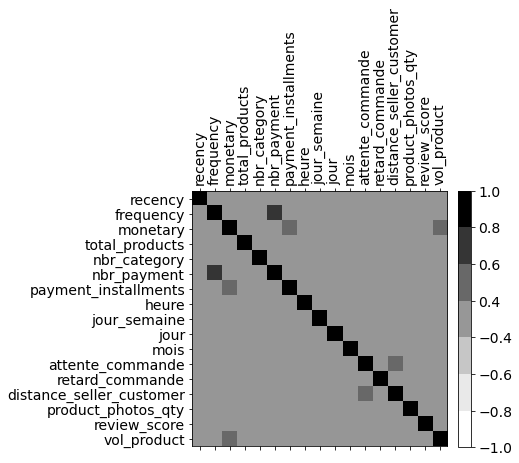

In [107]:
from matplotlib.colors import ListedColormap

col = data_olist.iloc[:,2:19].columns.tolist()

matrix = data_olist[col].corr()

plt.figure(figsize=[5,5])

boundaries = [-1,-0.8,-0.6,-0.4, 0.4, 0.6,0.8, 1]
norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256, extend='neither')

plt.matshow(matrix, norm=norm, cmap='Greys', fignum=1)

plt.xticks(range(len(col)), col, fontsize=14, rotation=90)
plt.yticks(range(len(col)), col, fontsize=14)

plt.colorbar(fraction=0.046, pad=0.04).ax.tick_params(labelsize=14)

plt.show()

Nous voyons qu'il y a quelques corrélations entre la fréquence et le nombre de type paiements, la somme dépensée et les versements et les volume des produits et le temps de réception d'une commande et la distance vendeur-client.
<a class="anchor" id="section_3_2_2"></a>
### Régression linéaire

L'équation de régression linéaire s'écrit 1.19x. Le coefficient R² vaut 0.308


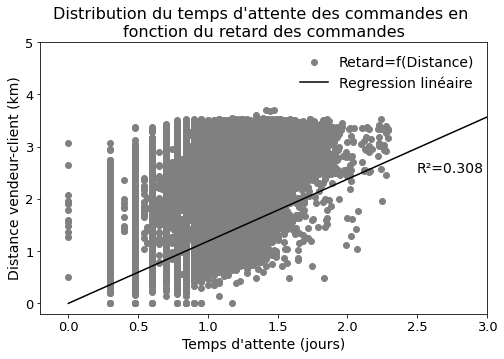

In [108]:
# Régression linéaire
X = data_olist[["attente_commande"]]
Y = data_olist["distance_seller_customer"]
X = X.copy() 
X['intercept'] = 1

result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a = result.params['attente_commande']
r_2 = (st.pearsonr(data_olist["attente_commande"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,2)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(8,5))

plt.scatter(data_olist["attente_commande"], Y, color="gray", label = "Retard=f(Distance)")
reg = np.linspace(0,3)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xlabel("Temps d'attente (jours)", fontsize=14)
plt.ylabel("Distance vendeur-client (km)", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(-0.2,3)
plt.ylim(-0.2,5)

plt.legend(fontsize=14, loc=1).get_frame().set_edgecolor("white")

plt.text(2.5,2.5, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution du temps d'attente des commandes en \nfonction du retard des commandes", fontsize=16)

plt.show()

L'équation de régression linéaire s'écrit 0.58x. Le coefficient R² vaut 0.167


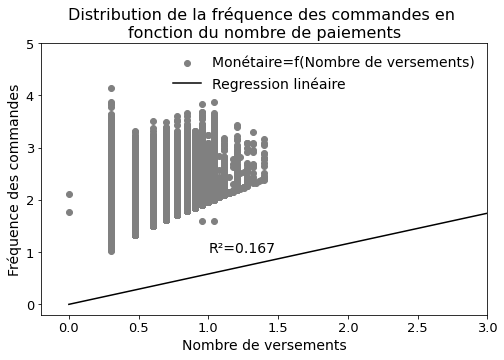

In [109]:
# Régression linéaire
X = data_olist[["payment_installments"]]
Y = data_olist["monetary"]
# Y = 10**Y_1
X = X.copy() 
X['intercept'] = 1

result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a = result.params['payment_installments']
r_2 = (st.pearsonr(data_olist["payment_installments"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,2)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(8,5))

plt.scatter(data_olist["payment_installments"], Y, color="gray", label = "Monétaire=f(Nombre de versements)")
reg = np.linspace(0,5)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xlabel("Nombre de versements", fontsize=14)
plt.ylabel("Fréquence des commandes", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.xlim(-0.2,3)
plt.ylim(-0.2,5)

plt.legend(fontsize=14, loc=1).get_frame().set_edgecolor("white")

plt.text(1,1, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution de la fréquence des commandes en \nfonction du nombre de paiements", fontsize=16)

plt.show()

L'équation de régression linéaire s'écrit 1.2x. Le coefficient R² vaut 0.39


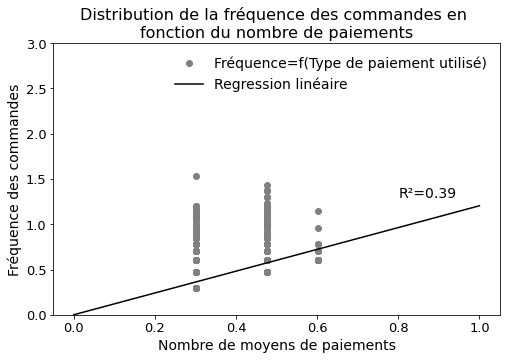

In [110]:
# Régression linéaire
X = data_olist[["nbr_payment"]]
Y = data_olist["frequency"]

X = X.copy() 
X['intercept'] = 1

result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a = result.params['nbr_payment']
r_2 = (st.pearsonr(data_olist["nbr_payment"],Y)[0])**2
print(f"L'équation de régression linéaire s'écrit {round(a,2)}x. Le coefficient R² vaut {round(r_2,3)}")

# Traçé du graphique et de la courbe de tendance

plt.figure(figsize=(8,5))

plt.scatter(data_olist["nbr_payment"], Y, color="gray", label = "Fréquence=f(Type de paiement utilisé)")
reg = np.linspace(0,1)
plt.plot(reg,[a*x for x in reg], color="black", label="Regression linéaire")

plt.xlabel("Nombre de moyens de paiements", fontsize=14)
plt.ylabel("Fréquence des commandes", fontsize=14)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

#plt.xlim(-5e4,1e6)
plt.ylim(0,3)

plt.legend(fontsize=14, loc=1).get_frame().set_edgecolor("white")

plt.text(0.8,1.3, f"R²={round(r_2,3)}", color ="black", fontsize=14)

plt.title("Distribution de la fréquence des commandes en \nfonction du nombre de paiements", fontsize=16)

plt.show()

Globalement, les variables sont très peu corrélées. 

Nous allons maintenant étudier les données via une Analyse en composante principale.
<a class="anchor" id="section_3_3"></a>
## Analyse multivariée
<a class="anchor" id="section_3_3_1"></a>
### Données brut

In [111]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x, y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(7, 7))
    
    couleurs = ["limegreen", "royalblue", "black", "magenta", "deepskyblue", "forestgreen", "goldenrod", "crimson",
                "grey", "indianred", "orange", "pink"]*4

    style_lignes = ["solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid",
                    "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", "dotted", 
                    "dotted", "dotted",
                    "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", "dashed", 
                    "dashed", "dashed",
                    "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", "dashdot", 
                    "dashdot", "dashdot", "dashdot"]
    
    important_feature = []
    important_color = []
    important_style_lignes = []
    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                 pca.components_[x, i],  
                 pca.components_[y, i],  
                 head_width=0.04,
                 head_length=0.04, 
                 #width=0.007,
                 linewidth=3,
                 color = couleurs[i],
                 ls = style_lignes[i])

        # Les labels
        if (np.abs(pca.components_[x, i])>0.2) | (np.abs(pca.components_[y, i])>0.2) :
            important_feature.append(features[i])
            important_color.append(couleurs[i])
            important_style_lignes.append(style_lignes[i])
            if ((pca.components_[x, i])<0) & ((pca.components_[y, i])<0) :
                plt.text(pca.components_[x, i] + 0.08,
                         pca.components_[y, i] - 0.08,
                         features[i],
                         color = couleurs[i],
                         fontsize=10,
                         weight="bold",
                         horizontalalignment="left")
            
            elif ((pca.components_[x, i])>0) & ((pca.components_[y, i])<0) :
                plt.text(pca.components_[x, i] + 0.05,
                         pca.components_[y, i] - (0.03-0.0006/((i+2)*0.006)),
                         features[i],
                         color = couleurs[i],
                         fontsize=10,
                         weight="bold",
                         horizontalalignment="left")
            elif ((pca.components_[x, i])>0) & ((pca.components_[y, i])>0) :
                plt.text(pca.components_[x, i] + 0.05,
                         pca.components_[y, i] - (0.03-0.0006/((i+1)*0.006)),
                         features[i],
                         color = couleurs[i],
                         fontsize=10,
                         weight="bold",
                         horizontalalignment="left")
                
            elif ((pca.components_[x, i])<0) & ((pca.components_[y, i])>0) :
                plt.text(pca.components_[x, i] + 0.05,
                         pca.components_[y, i] - (0.03-0.0006/((i+1)*0.006)),
                         features[i],
                         color = couleurs[i],
                         fontsize=10,
                         weight="bold",
                         horizontalalignment="left")

        
    custom_lines = []
    
    for i in range (0, len(important_feature), 1):
        custom_lines.append(Line2D([0], [0], color=important_color[i], linestyle=important_style_lignes[i], lw=4))
       
 
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({} %)'.format(x+1, round(100*pca.explained_variance_ratio_[x])),fontsize = 16)
    plt.ylabel('F{} ({} %)'.format(y+1, round(100*pca.explained_variance_ratio_[y])),fontsize = 16)


    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1), fontsize = 18)

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an), c="black")  # Add a unit circle for scale

    # Axes et affichage
    plt.axis('scaled')
    plt.legend(custom_lines, important_feature, frameon=False, bbox_to_anchor=(1, 1), fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show(block=False)

In [112]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[7,7], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque 
    composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,7)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1,figsize=(7,6))

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    plt.scatter(   X_[:, x], 
                        X_[:, y], 
                        alpha=alpha, 
                        c="grey", 
                        cmap="Set1", 
                        marker=marker)


    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} ({v1})', fontsize = 16)
    ax.set_ylabel(f'F{y+1} ({v2})', fontsize = 16)

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1
    
    # Pourcentage de valeurs dans chaque quart (Nord-Est, Sud-Est, Nord-Ouest et Sud-Ouest) de la projection
    n_e = np.where(((X_projected[:,x])>0) & ((X_projected[:,y])>0))
    n_e_list = list(chain.from_iterable(n_e))

    s_e = np.where(((X_projected[:,x])>0) & ((X_projected[:,y])<0))
    s_e_list = list(chain.from_iterable(s_e))

    n_o = np.where(((X_projected[:,x])<0) & ((X_projected[:,y])>0))
    n_o_list = list(chain.from_iterable(n_o))

    s_o = np.where(((X_projected[:,x])<0) & ((X_projected[:,y])<0))
    s_o_list = list(chain.from_iterable(s_o))

    n_n = np.where(((X_projected[:,x])==0) | ((X_projected[:,y])==0))
    n_n_list = list(chain.from_iterable(n_n))
    
    
    nbr_n_e = round(len(n_e_list)*100/len(X_projected),1)
    nbr_s_e = round(len(s_e_list)*100/len(X_projected),1)
    nbr_n_o = round(len(n_o_list)*100/len(X_projected),1)
    nbr_s_o = round(len(s_o_list)*100/len(X_projected),1)
    
    # Affichage de ces pourcentages dans leurs quarts respectifs 
    plt.text(0.75*x_max, 0.9*y_max, f"{round(nbr_n_e,3)}%", color ="firebrick", fontsize=14)
    plt.text(0.75*x_max, -0.95*y_max, f"{round(nbr_s_e,3)}%", color ="firebrick", fontsize=14)
    plt.text(-0.95*x_max, 0.9*y_max, f"{round(nbr_n_o,3)}%", color ="firebrick", fontsize=14)
    plt.text(-0.95*x_max, -0.95*y_max, f"{round(nbr_s_o,3)}%", color ="firebrick", fontsize=14)

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})", fontsize = 18)
    plt.show()

In [113]:
colonne = ['recency', 'frequency', 'monetary', 'total_products', 'nbr_category', 'nbr_payment', 'payment_installments', 
           'distance_seller_customer', 'review_score',
           'type_payment_boleto', 'type_payment_credit_card', 'type_payment_debit_card', 'type_payment_voucher',
           'main_category_Clothes', 'main_category_Electronics', 'main_category_Food', 'main_category_Health_body',
           'main_category_House', 'main_category_Other', 'main_category_Sport_leisure', 
           'heure_commande_Resting_hours', 'heure_commande_Working_hours', 
           'work_weekend_Weekend', 'work_weekend_Working_days', 
           'jour_commande_1st_forstnight', 'jour_commande_2nd_forstnight', 
           'mois_commande_1st_quarter', 'mois_commande_2nd_quarter', 'mois_commande_3rd_quarter', 'mois_commande_4th_quarter',
           'holidays_No', 'holidays_Yes'
          ]
from sklearn import model_selection, preprocessing, metrics

In [114]:
colonne_simplifié = ['Recency', 'Frequency', 'Monetary', 'Total products', "Nbr Category", 'Nbr payment', 'Installments', 
                     'Distance\nSeller/Customer', "Score",
                     'Boleto', 'Credit card', 'Debit card', 'Voucher',
                     'Clothes', 'Electronics', 'Food', 'Health_body', 'House', 'Other', 'Sport/leisure', 
                     'Resting hours', 'Working hours', 
                     'Weekend', 'Working days',
                     '1st fortnight', '2nd fortnight',
                     '1st quarter', '2nd quarter', '3rd quarter', '4th quarter',
                     'Work','Holidays']

array([3.964e+01, 1.172e+01, 9.050e+00, 7.530e+00, 5.880e+00, 5.620e+00,
       5.170e+00, 3.830e+00, 3.340e+00, 2.600e+00, 2.470e+00, 1.380e+00,
       6.700e-01, 3.700e-01, 2.300e-01, 1.800e-01, 1.000e-01, 9.000e-02,
       6.000e-02, 3.000e-02, 3.000e-02, 2.000e-02, 1.000e-02, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

array([ 40.,  51.,  60.,  68.,  74.,  79.,  85.,  88.,  92.,  94.,  97.,
        98.,  99.,  99., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100.])

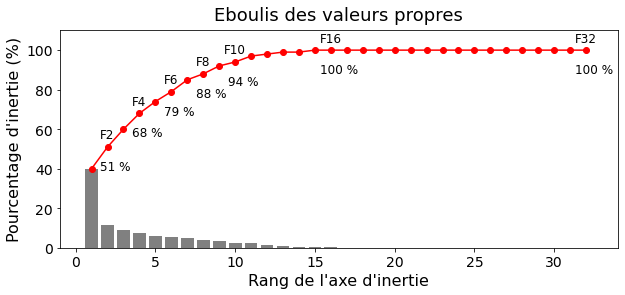

In [115]:
X = data_olist[colonne].values
names = data_olist[colonne].index
features = colonne_simplifié
scaler = preprocessing.RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

n_components = len(colonne)
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.figure(figsize=(10,4))

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18, pad=10)

plt.ylim(0,110)

for a,b in zip(x_list[1:10:2], scree_cum[1:10:2]): 
    plt.text(a+0.5, b-10, f"{int(b)} %",fontsize=12, va="center", ha="center")
    plt.text(a, b+6, f"F{int(a)}",fontsize=12, va="center", ha="center")
    
for a,b in zip(x_list[15::16], scree_cum[15::16]): 
    plt.text(a+0.5, b-10, f"{int(b)} %",fontsize=12, va="center", ha="center")
    plt.text(a, b+6, f"F{int(a)}",fontsize=12, va="center", ha="center")

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
# display(pcs.round(2))

array([39.64, 11.72,  9.05,  7.53,  5.88,  5.62,  5.17,  3.83,  3.34,
        2.6 ,  2.47,  1.38,  0.67,  0.37,  0.23,  0.18])

array([ 40.,  51.,  60.,  68.,  74.,  79.,  85.,  88.,  92.,  94.,  97.,
        98.,  99.,  99., 100., 100.])

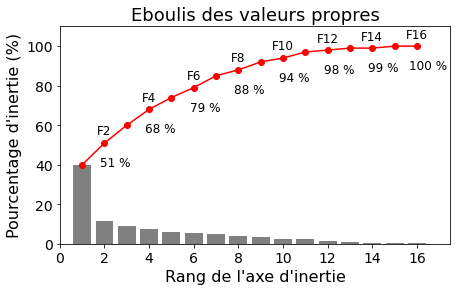

In [116]:
X = data_olist[colonne].values
names = data_olist[colonne].index
features = colonne_simplifié
scaler = preprocessing.RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

n_components = 16
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.figure(figsize=(7,4))

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18)

plt.xlim(0,17.5)
plt.ylim(0,110)

for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a+0.5, b-10, f"{int(b)} %",fontsize=12, va="center", ha="center")
    plt.text(a, b+6, f"F{int(a)}",fontsize=12, va="center", ha="center")

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
# display(pcs.round(2))

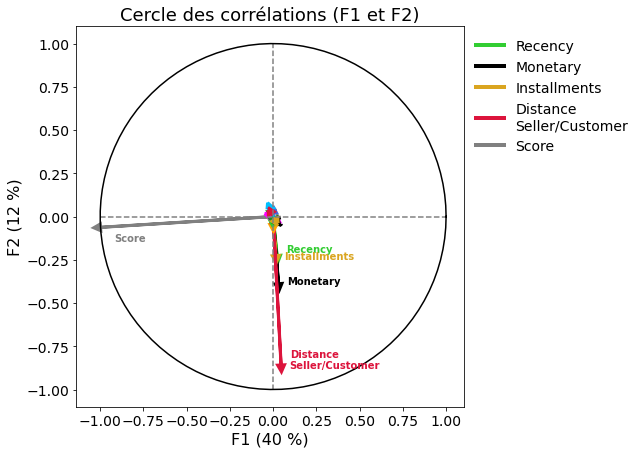

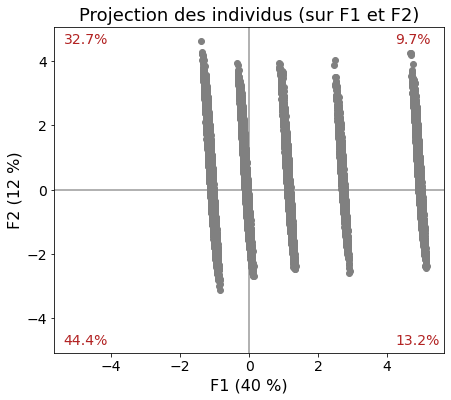

In [117]:
x_y = [0,1]
X_proj = pca.transform(X_scaled)

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

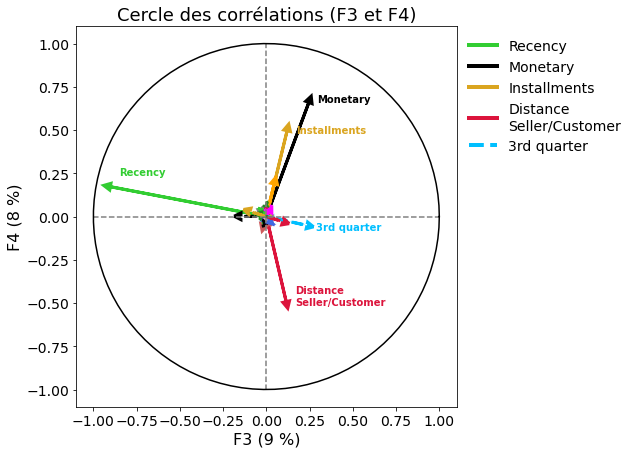

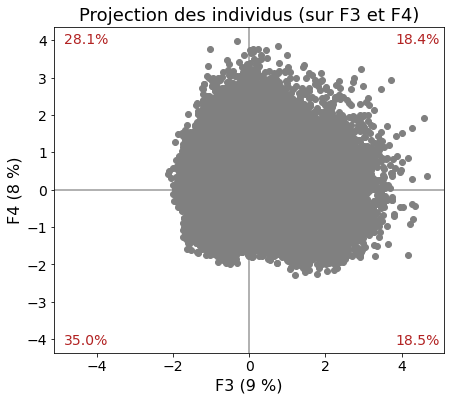

In [118]:
x_y = [2,3]

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

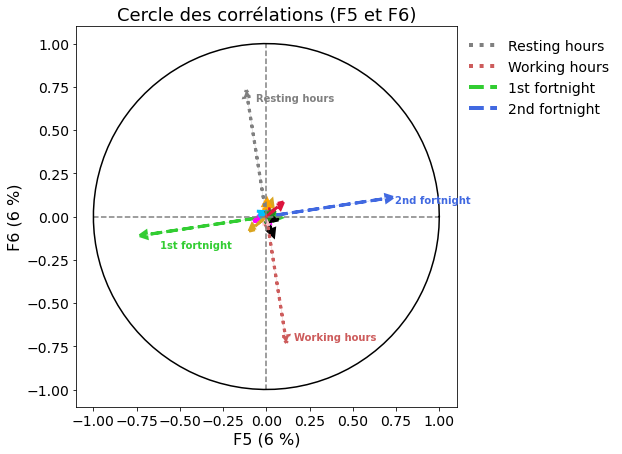

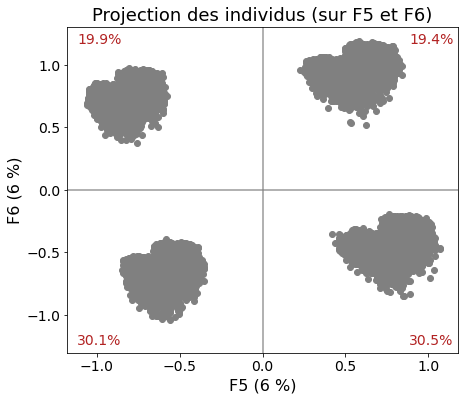

In [119]:
x_y = [4,5]

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

<a class="anchor" id="section_3_3_2"></a>
### Filtres

In [120]:
cp_1 = np.where((X_proj[:,0]>4) & (X_proj[:,1]>3.8))
cp_1_list = list(chain.from_iterable(cp_1))

cp_2 =  np.where((X_proj[:,0]>2) & (X_proj[:,0]<3) & (X_proj[:,1]>3.75))
cp_2_list = list(chain.from_iterable(cp_2))

cp_3 = np.where((X_proj[:,0]>-0.5) & (X_proj[:,0]<0) & (X_proj[:,1]>3.8))
cp_3_list = list(chain.from_iterable(cp_3))

cp_4 = np.where((X_proj[:,0]>-2) & (X_proj[:,0]<-1) & (X_proj[:,1]>4.5))
cp_4_list = list(chain.from_iterable(cp_4))

liste_ = cp_1_list + cp_2_list + cp_3_list + cp_4_list

result = [] 
for i in liste_: 
    if i not in result: 
        result.append(i) 

indexes_to_keep = set(range(data_olist.shape[0])) - set(result)
data_olist_2 = data_olist.take(list(indexes_to_keep))
display(data_olist_2.shape)
X_proj =[]

(93341, 42)

array([39.64, 11.71,  9.05,  7.53,  5.88,  5.62,  5.17,  3.83,  3.34,
        2.6 ,  2.47,  1.38,  0.67,  0.37,  0.23,  0.18])

array([ 40.,  51.,  60.,  68.,  74.,  79.,  85.,  88.,  92.,  94.,  97.,
        98.,  99.,  99.,  99., 100.])

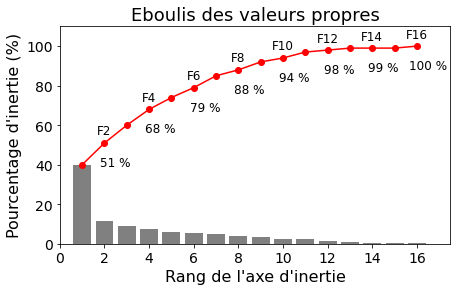

In [121]:
X = data_olist_2[colonne].values
names = data_olist_2[colonne].index
features = colonne_simplifié
scaler = preprocessing.RobustScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

n_components = 16
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
display(scree)
scree_cum = scree.cumsum().round()
display(scree_cum)


x_list = range(1, n_components+1)
list(x_list)

plt.figure(figsize=(7,4))

plt.bar(x_list, scree, color="gray")
plt.plot(x_list, scree_cum,c="red",marker='o')

plt.xlabel("Rang de l'axe d'inertie", fontsize=16)
plt.ylabel("Pourcentage d'inertie (%)",fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Eboulis des valeurs propres", fontsize=18)

plt.xlim(0,17.5)
plt.ylim(0,110)

for a,b in zip(x_list[1::2], scree_cum[1::2]): 
    plt.text(a+0.5, b-10, f"{int(b)} %",fontsize=12, va="center", ha="center")
    plt.text(a, b+6, f"F{int(a)}",fontsize=12, va="center", ha="center")

plt.show(block=False)

pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]


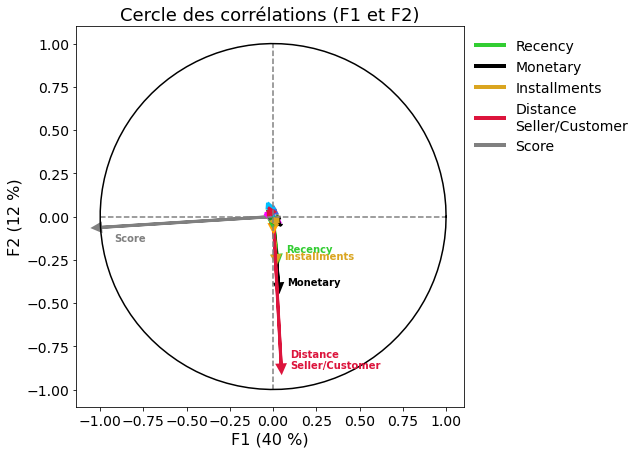

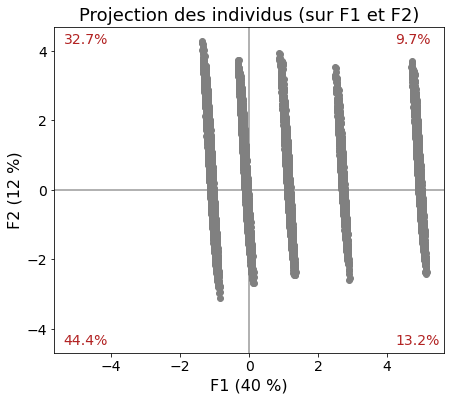

In [122]:
x_y = [0,1]
X_proj = pca.transform(X_scaled)

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

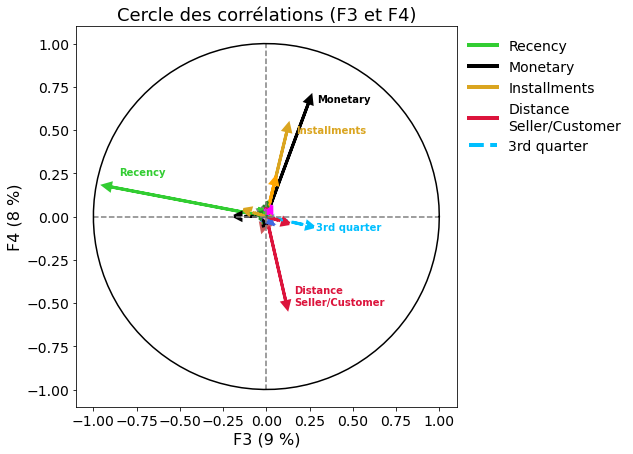

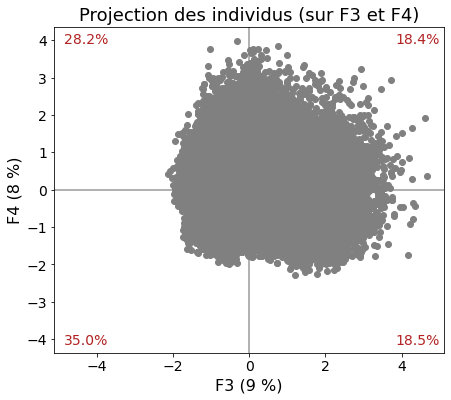

In [123]:
x_y = [2,3]

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

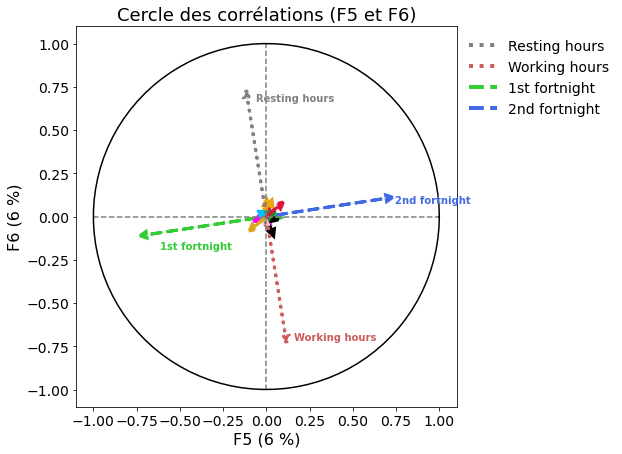

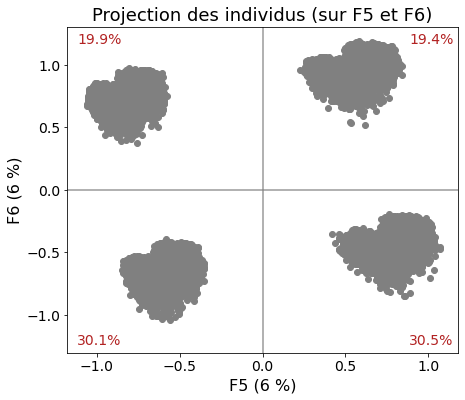

In [124]:
x_y = [4,5]

correlation_graph(pca, x_y, features)
display_factorial_planes(X_proj, x_y, pca, marker="o")

<a class="anchor" id="section_3_3_3"></a>
### Exportation des données

In [125]:
data_olist_2 = data_olist_2.reset_index(drop=True)

In [126]:
data_olist_2.to_csv('C:/Users/farid/Documents/Notebook/data_olist_after_pca_projet_5.csv')

<a class="anchor" id="section_3_4"></a>
## Données maintenance

Nous allons préparer des données pour la maintenance. Nous allons séparer les données en retirant à chaque fois les clients des 30 derniers jours. Nous aurons alors un fichier pour l'ensemble de la période (24 mois), puis pour 23 mois, 22 mois, 21 mois etc... 

Pour cela nous allons reprendre les fichiers utilisées pour la base client et créee une base client pour chaque période considérée.

In [127]:
olist_product.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117491 entries, 0 to 117490
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_unique_id  115035 non-null  object 
 1   order_id            117491 non-null  object 
 2   category_objects    117491 non-null  object 
 3   total_products      117491 non-null  int64  
 4   product_photos_qty  117491 non-null  float64
 5   vol_product         117471 non-null  float64
 6   nbr_category        115035 non-null  float64
 7   main_category       115035 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 8.1+ MB


In [128]:
olist_product["main_category_order_id"] = olist_product[["order_id", 
                                                         "category_objects"]].groupby(['order_id'])["category_objects"].transform('max')


In [129]:
olist_3 = olist_3.reset_index()
display(olist_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100756 entries, 0 to 100755
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   index                          100756 non-null  int64         
 1   customer_id                    100756 non-null  object        
 2   customer_unique_id             100756 non-null  object        
 3   customer_zip_code_prefix       100756 non-null  int64         
 4   customer_city                  100756 non-null  object        
 5   customer_state                 100756 non-null  object        
 6   order_id                       100756 non-null  object        
 7   order_status                   100756 non-null  object        
 8   order_purchase_timestamp       100756 non-null  datetime64[ns]
 9   order_approved_at              100742 non-null  datetime64[ns]
 10  order_delivered_carrier_date   100754 non-null  datetime64[ns]
 11  

None

In [130]:
olist_3_grouped = olist_3.groupby(["order_id", "customer_unique_id"], 
                                  as_index=False).agg({"order_purchase_timestamp" : "max",
                                                       "payment_installments" : "mean",
                                                       "payment_value" : "sum",
                                                       "heure" : "mean", 
                                                       "jour" : "mean", 
                                                       "jour_semaine" : "mean", 
                                                       "mois" : "mean", 
                                                       "last_commande" : "mean", 
                                                       "attente_commande" : "mean", 
                                                       "retard_commande" : "mean", 
                                                       "nbr_payment" : "mean", 
                                                       "type_payment" : "max", 
                                                       "review_score" : "mean"})

In [131]:
display(olist_3_grouped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96477 entries, 0 to 96476
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96477 non-null  object        
 1   customer_unique_id        96477 non-null  object        
 2   order_purchase_timestamp  96477 non-null  datetime64[ns]
 3   payment_installments      96477 non-null  float64       
 4   payment_value             96477 non-null  float64       
 5   heure                     96477 non-null  float64       
 6   jour                      96477 non-null  float64       
 7   jour_semaine              96477 non-null  float64       
 8   mois                      96477 non-null  float64       
 9   last_commande             96477 non-null  float64       
 10  attente_commande          96477 non-null  float64       
 11  retard_commande           96477 non-null  float64       
 12  nbr_payment       

None

In [132]:
olist_distance_sell_cust = olist_4[["order_id", "distance_seller_customer"]].groupby("order_id", as_index=False).mean()
olist_grouped_product = olist_product.groupby("order_id", as_index=False).agg({"total_products" : "max", 
                                                                               "vol_product" : "mean",
                                                                               "nbr_category" : "mean", 
                                                                               "main_category_order_id" : "max",
                                                                               "product_photos_qty" : "mean"})

In [133]:
olist_3_4 = pd.merge(olist_3_grouped, olist_distance_sell_cust, 
                     on="order_id", how="outer")
olist_maintenance = pd.merge(olist_3_4, olist_grouped_product, 
                             on="order_id", how="outer")
display(olist_maintenance.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  99441 non-null  object        
 1   customer_unique_id        96477 non-null  object        
 2   order_purchase_timestamp  96477 non-null  datetime64[ns]
 3   payment_installments      96477 non-null  float64       
 4   payment_value             96477 non-null  float64       
 5   heure                     96477 non-null  float64       
 6   jour                      96477 non-null  float64       
 7   jour_semaine              96477 non-null  float64       
 8   mois                      96477 non-null  float64       
 9   last_commande             96477 non-null  float64       
 10  attente_commande          96477 non-null  float64       
 11  retard_commande           96477 non-null  float64       
 12  nbr_payment       

None

In [134]:
olist_maintenance = olist_maintenance.sort_values("order_purchase_timestamp")
display(olist_maintenance.head())

,order_id,customer_unique_id,order_purchase_timestamp,payment_installments,payment_value,heure,jour,jour_semaine,mois,last_commande,...,retard_commande,nbr_payment,type_payment,review_score,distance_seller_customer,total_products,vol_product,nbr_category,main_category_order_id,product_photos_qty
22362,3b697a20d9e427646d92567910af6d57,32ea3bdedab835c3aa6cb68ce66565ef,2016-10-03 09:44:50,1.0,45.46,9.0,3.0,0.0,10.0,695.0,...,0.0,3.0,voucher,4.0,708.309,1.0,4096.0,2.0,Sport_leisure,3.0
71722,be5bc2f0da14d8071e2d45451ad119d9,2f64e403852e6893ae37485d5fcacdaf,2016-10-03 16:56:50,1.0,39.09,16.0,3.0,0.0,10.0,695.0,...,10.0,1.0,boleto,4.0,915.471,1.0,4096.0,1.0,Sport_leisure,1.0
61550,a41c8759fbe7aab36ea07e038b2d4465,61db744d2f835035a5625b59350c6b63,2016-10-03 21:13:36,1.0,53.73,21.0,3.0,0.0,10.0,695.0,...,25.0,1.0,boleto,3.0,817.606,1.0,4160.0,1.0,Sport_leisure,1.0
79245,d207cc272675637bfed0062edffd0818,8d3a54507421dbd2ce0a1d58046826e0,2016-10-03 22:06:03,6.0,133.46,22.0,3.0,0.0,10.0,695.0,...,22.0,1.0,credit_card,1.0,211.851,1.0,14960.0,1.0,House,1.0
77364,cd3b8574c82b42fc8129f6d502690c3e,87776adb449c551e74c13fc34f036105,2016-10-03 22:31:31,4.0,40.95,22.0,3.0,0.0,10.0,695.0,...,39.0,1.0,credit_card,5.0,194.289,1.0,2640.0,1.0,Clothes,2.0


In [135]:
olist_maintenance = olist_maintenance.loc[olist_maintenance["customer_unique_id"].notnull(),:]
olist_maintenance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96477 entries, 22362 to 20162
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  96477 non-null  object        
 1   customer_unique_id        96477 non-null  object        
 2   order_purchase_timestamp  96477 non-null  datetime64[ns]
 3   payment_installments      96477 non-null  float64       
 4   payment_value             96477 non-null  float64       
 5   heure                     96477 non-null  float64       
 6   jour                      96477 non-null  float64       
 7   jour_semaine              96477 non-null  float64       
 8   mois                      96477 non-null  float64       
 9   last_commande             96477 non-null  float64       
 10  attente_commande          96477 non-null  float64       
 11  retard_commande           96477 non-null  float64       
 12  nbr_payment   

In [136]:
olist_maintenance.to_csv('C:/Users/farid/Documents/Notebook/olist_maintenance_raw_projet_5.csv')